# DWI Preprocessing Pipeline - Step-by-Step with Visualizations

This notebook provides a comprehensive, step-by-step DWI preprocessing pipeline with:
- **Clear visualization** of each preprocessing step using FSL tools
- **Quality control (QC)** checks at each stage
- **Interactive single-subject processing** (recommended for learning/debugging)
- **Batch processing** option for multiple subjects

## Pipeline Overview

1. **Data Loading & Conversion** - Convert NIfTI to MRtrix format
2. **Denoising** - Remove thermal noise using MP-PCA
3. **Gibbs Ringing Removal** - Remove truncation artifacts
4. **Distortion Correction** - Correct EPI distortions (topup + eddy or dwifslpreproc)
5. **Bias Field Correction** - Correct B1 field inhomogeneities
6. **Brain Mask Generation** - Create brain mask
7. **Response Function Estimation** - Estimate WM response function
8. **FOD Estimation** - Estimate fiber orientation distributions
9. **T1 Processing** - Generate 5TT segmentation
10. **DWI-T1 Coregistration** - Align DWI to T1 space
11. **DTI Metrics** - Compute FA, MD, AD, RD maps
12. **Tractography** - Generate streamlines
13. **SIFT2 Filtering** - Filter streamlines using SIFT2

## Usage

- **Single Subject (Interactive)**: Run cells sequentially, visualize each step
- **Batch Processing**: Use the batch processing cell at the end


## Setup and Imports


In [24]:
import os
import sys
import subprocess
import json
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Interactive widgets for slice navigation
try:
    import ipywidgets as widgets
    from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
    from IPython.display import display
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠️  ipywidgets not available. Install with: pip install ipywidgets")
    print("   Interactive slice viewer will not be available.")
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import nibabel as nib
from scipy import stats
from scipy.ndimage import label
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# MRtrix and FSL tools (check availability)
def find_command(cmd):
    """Find command in PATH or common FSL/MRtrix locations"""
    # Try PATH first
    path = shutil.which(cmd)
    if path:
        return True, path
    
    # Try common FSL locations
    fsl_dir = os.environ.get('FSLDIR', '/media/RCPNAS/Data/Delirium/fsl')
    fsl_paths = [
        Path(fsl_dir) / 'bin' / cmd,
        Path(fsl_dir) / 'share' / 'fsl' / 'bin' / cmd,
    ]
    for fsl_path in fsl_paths:
        if fsl_path.exists():
            return True, str(fsl_path)
    
    return False, None

# Check required tools and store their paths
tools = {}
tool_paths = {}
# Required tools
required_tools = ['mrconvert', 'dwidenoise', 'mrdegibbs', 'topup', 'eddy', 
                  'dwifslpreproc', 'dwibiascorrect', 'dwi2mask', 'dwi2response', 
                  'dwi2fod', '5ttgen', 'dwi2tensor', 'tensor2metric', 'tckgen', 
                  'tcksift2', 'fslmaths', 'fsleyes', 'mrview']
# Optional/deprecated tools
optional_tools = ['fslview']  # Deprecated, replaced by fsleyes

for cmd in required_tools + optional_tools:
    found, path = find_command(cmd)
    tools[cmd] = found
    if found:
        tool_paths[cmd] = path

print("Tool availability:")
print("Required tools:")
for tool in required_tools:
    available = tools.get(tool, False)
    status = "✓" if available else "✗"
    path_info = f" ({tool_paths.get(tool, '')})" if available else ""
    print(f"  {status} {tool}{path_info}")

print("\nOptional tools:")
for tool in optional_tools:
    available = tools.get(tool, False)
    status = "✓" if available else "✗ (optional/deprecated)"
    path_info = f" ({tool_paths.get(tool, '')})" if available else ""
    if tool == 'fslview' and not available:
        path_info = " (deprecated - use fsleyes instead)"
    print(f"  {status} {tool}{path_info}")

# Configuration
ROOT = Path("/media/RCPNAS/Data/Delirium/Delirium_Rania")
BASE_DIR = ROOT / "Preproc_current"
RAW_DIR = ROOT / "rawdata_new"

# Subject ID (change this for different subjects)
SUBJ_ID = "sub-AF"  

print(f"\nBase directory: {BASE_DIR}")
print(f"Subject ID: {SUBJ_ID}")
print(f"Subject directory: {BASE_DIR / SUBJ_ID}")


Tool availability:
Required tools:
  ✓ mrconvert (/usr/local/anaconda3/bin/mrconvert)
  ✓ dwidenoise (/usr/local/anaconda3/bin/dwidenoise)
  ✓ mrdegibbs (/usr/local/anaconda3/bin/mrdegibbs)
  ✓ topup (/media/RCPNAS/Data/Delirium/fsl/share/fsl/bin/topup)
  ✓ eddy (/media/RCPNAS/Data/Delirium/fsl/share/fsl/bin/eddy)
  ✓ dwifslpreproc (/usr/local/anaconda3/bin/dwifslpreproc)
  ✓ dwibiascorrect (/usr/local/anaconda3/bin/dwibiascorrect)
  ✓ dwi2mask (/usr/local/anaconda3/bin/dwi2mask)
  ✓ dwi2response (/usr/local/anaconda3/bin/dwi2response)
  ✓ dwi2fod (/usr/local/anaconda3/bin/dwi2fod)
  ✓ 5ttgen (/usr/local/anaconda3/bin/5ttgen)
  ✓ dwi2tensor (/usr/local/anaconda3/bin/dwi2tensor)
  ✓ tensor2metric (/usr/local/anaconda3/bin/tensor2metric)
  ✓ tckgen (/usr/local/anaconda3/bin/tckgen)
  ✓ tcksift2 (/usr/local/anaconda3/bin/tcksift2)
  ✓ fslmaths (/media/RCPNAS/Data/Delirium/fsl/share/fsl/bin/fslmaths)
  ✓ fsleyes (/media/RCPNAS/Data/Delirium/fsl/share/fsl/bin/fsleyes)
  ✓ mrview (/usr/local

In [26]:
# Ensure directories exist and check data availability
# Create base directory if it doesn't exist
BASE_DIR.mkdir(parents=True, exist_ok=True)
print(f"✓ Base directory: {BASE_DIR} (created if needed)")

# Create subject directory if it doesn't exist
subj_dir = BASE_DIR / SUBJ_ID
subj_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Subject directory: {subj_dir} (created if needed)")

# Check if raw data exists (for potential conversion)
raw_subj_dir = RAW_DIR / SUBJ_ID
if raw_subj_dir.exists():
    print(f"✓ Raw data found: {raw_subj_dir}")
    print(f"   This is the source for convert_and_organize.sh")
else:
    print(f"⚠️  Raw data not found: {raw_subj_dir}")
    print(f"   Note: If you need to convert from rawdata_new, run convert_and_organize.sh first")
    print(f"   The script will create Preproc_current/ with properly named files")

✓ Base directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current (created if needed)
✓ Subject directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF (created if needed)
✓ Raw data found: /media/RCPNAS/Data/Delirium/Delirium_Rania/rawdata_new/sub-AF
   This is the source for convert_and_organize.sh


## Helper Functions for Visualization and QC


In [31]:
def load_image(path, required=True):
    """Load NIfTI or MIF image"""
    path = Path(path)
    if not path.exists():
        if required:
            raise FileNotFoundError(f"Required file not found: {path}")
        return None
    
    # Convert .mif to .nii.gz temporarily if needed
    if path.suffix == '.mif':
        temp_nii = path.parent / f"_temp_{path.stem}.nii.gz"
        # Use the full path to mrconvert if available
        mrconvert_cmd = tool_paths.get('mrconvert', 'mrconvert')
        result = subprocess.run([mrconvert_cmd, str(path), str(temp_nii), '-force'], 
                      check=False, capture_output=True, text=True)
        if result.returncode != 0:
            if required:
                raise RuntimeError(f"Failed to convert .mif file: {result.stderr}")
            return None
        if temp_nii.exists():
            # Load the image and read data into memory to avoid lazy loading issues
            temp_img = nib.load(str(temp_nii))
            # Load data into memory as numpy array
            data = temp_img.get_fdata()
            # Create a new image from the in-memory data (no file dependency)
            img = nib.Nifti1Image(data, temp_img.affine, temp_img.header)
            # Now we can safely delete the temp file
            temp_nii.unlink()
            return img
        else:
            if required:
                raise FileNotFoundError(f"Conversion failed: temp file not created: {temp_nii}")
            return None
    else:
        return nib.load(str(path))

def get_mid_slices(data, axis=2):
    """Get middle slices for visualization with proper neuroimaging orientation
    
    Standard neuroimaging convention:
    - Axial (axis=2): viewed from below - anterior at top, left on left
    - Coronal (axis=1): viewed from behind - superior at top, left on left  
    - Sagittal (axis=0): viewed from left - anterior at right, superior at top
    
    Rotates slices 90 degrees counterclockwise to match radiological convention.
    """
    if data.ndim == 3:
        mid = data.shape[axis] // 2
        if axis == 0:  # Sagittal
            slice_data = data[mid, :, :]
            # Rotate 90 degrees counterclockwise for proper orientation
            return np.rot90(slice_data, k=1)
        elif axis == 1:  # Coronal
            slice_data = data[:, mid, :]
            # Rotate 90 degrees counterclockwise for proper orientation
            return np.rot90(slice_data, k=1)
        else:  # Axial (axis=2)
            slice_data = data[:, :, mid]
            # Rotate 90 degrees counterclockwise for proper orientation
            return np.rot90(slice_data, k=1)
    elif data.ndim == 4:
        # For 4D, take mean across time and then middle slice
        mean_3d = np.mean(data, axis=3)
        mid = mean_3d.shape[axis] // 2
        if axis == 0:  # Sagittal
            slice_data = mean_3d[mid, :, :]
            return np.rot90(slice_data, k=1)
        elif axis == 1:  # Coronal
            slice_data = mean_3d[:, mid, :]
            return np.rot90(slice_data, k=1)
        else:  # Axial (axis=2)
            slice_data = mean_3d[:, :, mid]
            return np.rot90(slice_data, k=1)
    return None

def interactive_slice_viewer(before_data, after_data, before_title="Before", after_title="After",
                            mask_data=None, axis=2, cmap='gray'):
    """Interactive slice viewer with sliders to navigate through slices.
    
    Args:
        before_data: 3D numpy array (before preprocessing)
        after_data: 3D numpy array (after preprocessing)
        before_title: Title for before image
        after_title: Title for after image
        mask_data: Optional 3D mask array for overlay
        axis: Which axis to view (0=sagittal, 1=coronal, 2=axial)
        cmap: Colormap to use
    """
    if not WIDGETS_AVAILABLE:
        print("⚠️  ipywidgets not available. Using static plot instead.")
        return plot_comparison(before_data, after_data, before_title, after_title, mask_data, cmap=cmap)
    
    # Ensure 3D
    if before_data.ndim == 4:
        before_data = np.mean(before_data, axis=3)
    if after_data.ndim == 4:
        after_data = np.mean(after_data, axis=3)
    if mask_data is not None and mask_data.ndim == 4:
        mask_data = np.mean(mask_data, axis=3)
    
    # Get dimensions
    n_slices = before_data.shape[axis]
    
    # Calculate intensity range
    vmin = min(np.percentile(before_data[before_data > 0], 1) if np.any(before_data > 0) else 0,
               np.percentile(after_data[after_data > 0], 1) if np.any(after_data > 0) else 0)
    vmax = max(np.percentile(before_data, 99), np.percentile(after_data, 99))
    
    # Create figure - use output widget for proper display
    from IPython.display import clear_output
    output = widgets.Output()
    
    # Store current axis in a mutable container
    current_axis = {'value': axis}
    
    def update_slice_with_axis(slice_idx, view_axis):
        """Update slice with specified axis"""
        with output:
            clear_output(wait=True)
            
            # Create new figure for each update
            fig, axes = plt.subplots(1, 2, figsize=(14, 7))
            
            # Get slice based on current axis
            if view_axis == 0:  # Sagittal
                before_slice = np.rot90(before_data[slice_idx, :, :], k=1)
                after_slice = np.rot90(after_data[slice_idx, :, :], k=1)
                mask_slice = np.rot90(mask_data[slice_idx, :, :], k=1) if mask_data is not None else None
                axis_name = "Sagittal"
            elif view_axis == 1:  # Coronal
                before_slice = np.rot90(before_data[:, slice_idx, :], k=1)
                after_slice = np.rot90(after_data[:, slice_idx, :], k=1)
                mask_slice = np.rot90(mask_data[:, slice_idx, :], k=1) if mask_data is not None else None
                axis_name = "Coronal"
            else:  # Axial
                before_slice = np.rot90(before_data[:, :, slice_idx], k=1)
                after_slice = np.rot90(after_data[:, :, slice_idx], k=1)
                mask_slice = np.rot90(mask_data[:, :, slice_idx], k=1) if mask_data is not None else None
                axis_name = "Axial"
            
            n_slices_axis = before_data.shape[view_axis]
            
            # Plot before
            im1 = axes[0].imshow(before_slice, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect='auto')
            axes[0].set_title(f"{before_title} - {axis_name} Slice {slice_idx}/{n_slices_axis-1}", fontsize=12, fontweight='bold')
            axes[0].axis('off')
            plt.colorbar(im1, ax=axes[0], fraction=0.046)
            
            # Plot after
            im2 = axes[1].imshow(after_slice, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower', aspect='auto')
            if mask_slice is not None:
                axes[1].imshow(mask_slice, cmap='Reds', alpha=0.3, origin='lower', aspect='auto')
            axes[1].set_title(f"{after_title} - {axis_name} Slice {slice_idx}/{n_slices_axis-1}", fontsize=12, fontweight='bold')
            axes[1].axis('off')
            plt.colorbar(im2, ax=axes[1], fraction=0.046)
            
            plt.tight_layout()
            plt.show()
    
    # Update the original update_slice to use current axis
    def update_slice(slice_idx):
        update_slice_with_axis(slice_idx, current_axis['value'])
    
    # Create slider
    slice_slider = widgets.IntSlider(
        value=n_slices // 2,
        min=0,
        max=n_slices - 1,
        step=1,
        description='Slice:',
        style={'description_width': 'initial'},
        layout=Layout(width='500px')
    )
    
    # Create axis selector
    axis_selector = widgets.RadioButtons(
        options=[('Sagittal', 0), ('Coronal', 1), ('Axial', 2)],
        value=axis,
        description='View:',
        style={'description_width': 'initial'}
    )
    
    def on_axis_change(change):
        """Update when axis changes"""
        current_axis['value'] = change['new']
        new_n_slices = before_data.shape[current_axis['value']]
        slice_slider.max = new_n_slices - 1
        slice_slider.value = new_n_slices // 2
        # Update the slice display
        update_slice_with_axis(slice_slider.value, current_axis['value'])
    
    axis_selector.observe(on_axis_change, names='value')
    slice_slider.observe(lambda change: update_slice(change['new']), names='value')
    
    # Initial display
    update_slice_with_axis(n_slices // 2, axis)
    
    # Display controls and output
    display(VBox([axis_selector, slice_slider, output]))
    
    return output

def plot_comparison(before, after, before_title="Before", after_title="After", 
                   mask=None, vmin=None, vmax=None, cmap='gray'):
    """Plot before/after comparison"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Get middle slices for each orientation
    for i, axis in enumerate([0, 1, 2]):
        before_slice = get_mid_slices(before, axis=axis)
        after_slice = get_mid_slices(after, axis=axis)
        
        if before_slice is None or after_slice is None:
            continue
            
        # Determine intensity range
        if vmin is None:
            vmin = min(np.percentile(before_slice[before_slice > 0], 1) if np.any(before_slice > 0) else 0,
                      np.percentile(after_slice[after_slice > 0], 1) if np.any(after_slice > 0) else 0)
        if vmax is None:
            vmax = max(np.percentile(before_slice, 99),
                      np.percentile(after_slice, 99))
        
        # Before
        im1 = axes[0, i].imshow(before_slice, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        axes[0, i].set_title(f"{before_title} - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
        axes[0, i].axis('off')
        plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
        
        # After
        im2 = axes[1, i].imshow(after_slice, cmap=cmap, vmin=vmin, vmax=vmax, origin='lower')
        axes[1, i].set_title(f"{after_title} - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
        axes[1, i].axis('off')
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
    
    plt.tight_layout()
    return fig

def compute_snr(data, mask=None, noise_std=None):
    """Compute SNR: mean signal / std of noise"""
    if mask is not None:
        data_masked = data[mask > 0.5]
    else:
        data_masked = data[data > 0]
    
    if len(data_masked) == 0:
        return None
    
    mean_signal = np.mean(data_masked)
    
    if noise_std is not None:
        snr = mean_signal / noise_std if noise_std > 0 else None
    else:
        # Estimate noise from background (lowest 10% of values)
        sorted_vals = np.sort(data_masked)
        noise_est = np.std(sorted_vals[:len(sorted_vals)//10])
        snr = mean_signal / noise_est if noise_est > 0 else None
    
    return snr, mean_signal, noise_std if noise_std is not None else noise_est

def qc_summary(step_name, metrics):
    """Print QC summary"""
    print(f"\n{'='*60}")
    print(f"QC Summary: {step_name}")
    print(f"{'='*60}")
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    print(f"{'='*60}\n")

def run_command(cmd, check=True, capture_output=True, shell=False):
    """Run shell command and return result"""
    if shell:
        # If shell=True, cmd should be a string
        result = subprocess.run(cmd, shell=True, capture_output=capture_output, text=True, check=check)
    else:
        # If shell=False, cmd can be string or list
        if isinstance(cmd, str):
            cmd = cmd.split()
        result = subprocess.run(cmd, capture_output=capture_output, text=True, check=check)
    
    if result.returncode != 0 and check:
        cmd_str = cmd if isinstance(cmd, str) else ' '.join(cmd)
        print(f"Error running: {cmd_str}")
        if result.stderr:
            print(result.stderr)
    return result

print("Helper functions loaded!")


Helper functions loaded!


## Step 1: Data Loading & Conversion

Convert NIfTI DWI data to MRtrix format (.mif) for processing.


In [28]:
# ============================================================================
# STEP 1a: Setup and File Detection
# ============================================================================
print("=" * 70)
print("STEP 1: Data Loading & Conversion - Part 1: Setup")
print("=" * 70)

# Check that required variables are defined
if 'BASE_DIR' not in globals() or 'SUBJ_ID' not in globals():
    raise NameError("BASE_DIR or SUBJ_ID not defined! Please run the configuration cells first.")

print(f"✓ Variables check passed: BASE_DIR={BASE_DIR}, SUBJ_ID={SUBJ_ID}")

# Change to subject directory
subj_dir = BASE_DIR / SUBJ_ID
subj_dir.mkdir(parents=True, exist_ok=True)
print(f"✓ Subject directory: {subj_dir}")

# Change working directory
original_dir = os.getcwd()
try:
    os.chdir(subj_dir)
    print(f"✓ Changed to working directory: {os.getcwd()}")
except Exception as e:
    print(f"⚠️  Warning: Could not change to {subj_dir}: {e}")
    print(f"   Continuing with current directory: {os.getcwd()}")

# Check for input files
SUBJ_PREFIX = SUBJ_ID
# The convert_and_organize.sh script uses AP_A (Anterior) and AP_P (Posterior) naming
ap_dwi = subj_dir / f"{SUBJ_PREFIX}_AP_A_dwi.nii.gz"
pa_dwi = subj_dir / f"{SUBJ_PREFIX}_AP_P_dwi.nii.gz"
ap_bval = subj_dir / f"{SUBJ_PREFIX}_AP_A_dwi.bval"
ap_bvec = subj_dir / f"{SUBJ_PREFIX}_AP_A_dwi.bvec"
pa_bval = subj_dir / f"{SUBJ_PREFIX}_AP_P_dwi.bval"
pa_bvec = subj_dir / f"{SUBJ_PREFIX}_AP_P_dwi.bvec"

# Fallback to legacy naming (AP and PA) if new naming not found
if not ap_dwi.exists():
    ap_dwi = subj_dir / f"{SUBJ_PREFIX}_AP_dwi.nii.gz"
    ap_bval = subj_dir / f"{SUBJ_PREFIX}_AP_dwi.bval"
    ap_bvec = subj_dir / f"{SUBJ_PREFIX}_AP_dwi.bvec"

if not pa_dwi.exists():
    pa_dwi = subj_dir / f"{SUBJ_PREFIX}_PA_dwi.nii.gz"
    pa_bval = subj_dir / f"{SUBJ_PREFIX}_PA_dwi.bval" if pa_dwi.exists() else None
    pa_bvec = subj_dir / f"{SUBJ_PREFIX}_PA_dwi.bvec" if pa_dwi.exists() else None
else:
    pa_bval = pa_bval if pa_bval.exists() else None
    pa_bvec = pa_bvec if pa_bvec.exists() else None

# Determine which DWI to use
if ap_dwi.exists():
    dwi_nii = ap_dwi
    dwi_bval = ap_bval
    dwi_bvec = ap_bvec
    print(f"✓ Found AP DWI: {dwi_nii}")
elif pa_dwi.exists():
    dwi_nii = pa_dwi
    dwi_bval = pa_bval
    dwi_bvec = pa_bvec
    print(f"✓ Found PA DWI: {dwi_nii}")
else:
    raise FileNotFoundError(f"No DWI files found for {SUBJ_ID}")


STEP 1: Data Loading & Conversion - Part 1: Setup
✓ Variables check passed: BASE_DIR=/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current, SUBJ_ID=sub-AF
✓ Subject directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF
✓ Changed to working directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF
✓ Found PA DWI: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.nii.gz


STEP 1: Data Loading & Conversion - Part 2: Conversion & QC

Converting DWI to .mif format...
  Input: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.nii.gz
  Output: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_dwi.mif
  bvec: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.bvec
  bval: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.bval
✓ DWI dimensions: 130 132 75 69
✓ Data shape: (130, 132, 75, 69)
✓ Data type: float64
✓ Intensity range: [0.00, 2504.00]


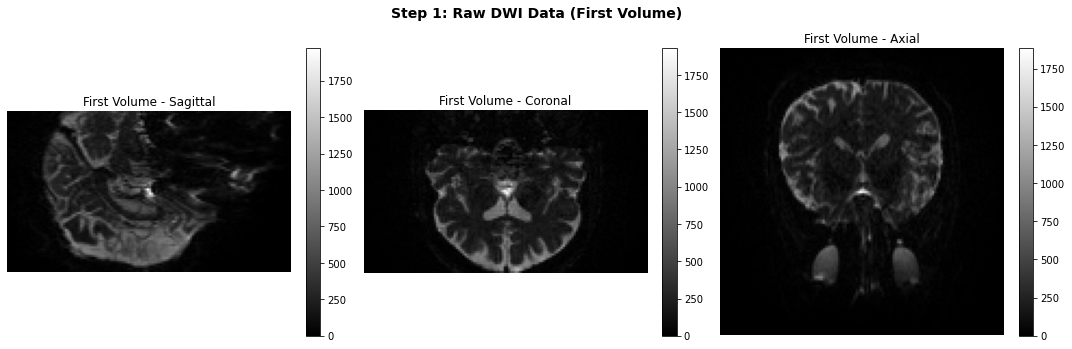


QC Summary: Step 1: Data Loading
  n_volumes: 69
  voxel_size: (1.8, 1.8, 1.8)
  mean_intensity: 27.6175
  std_intensity: 54.1817



In [ ]:
# ============================================================================
# STEP 1b: Convert to .mif and QC
# ============================================================================
print("=" * 70)
print("STEP 1: Data Loading & Conversion - Part 2: Conversion & QC")
print("=" * 70)

# Convert to .mif format
dwi_mif = subj_dir / f"{SUBJ_PREFIX}_dwi.mif"
print(f"\nConverting DWI to .mif format...")
print(f"  Input: {dwi_nii}")
print(f"  Output: {dwi_mif}")
print(f"  bvec: {dwi_bvec}")
print(f"  bval: {dwi_bval}")

# Check if mrconvert is available
if not tools.get('mrconvert', False):
    raise RuntimeError("mrconvert not found! Please check your MRtrix installation.")

# Use the full path if available
mrconvert_cmd = tool_paths.get('mrconvert', 'mrconvert')
run_command([mrconvert_cmd, str(dwi_nii), str(dwi_mif), 
             '-fslgrad', str(dwi_bvec), str(dwi_bval), '-force'])

# QC: Check data dimensions and basic stats
if dwi_mif.exists():
    result = run_command(['mrinfo', str(dwi_mif), '-size'], capture_output=True)
    size_info = result.stdout.strip()
    print(f"✓ DWI dimensions: {size_info}")
    
    # Load and visualize first volume
    dwi_img = load_image(dwi_mif)
    if dwi_img:
        dwi_data = dwi_img.get_fdata()
        print(f"✓ Data shape: {dwi_data.shape}")
        print(f"✓ Data type: {dwi_data.dtype}")
        print(f"✓ Intensity range: [{dwi_data.min():.2f}, {dwi_data.max():.2f}]")
        
        # Extract first b0 volume for visualization
        first_vol = dwi_data[:, :, :, 0] if dwi_data.ndim == 4 else dwi_data
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, axis in enumerate([0, 1, 2]):
            slice_data = get_mid_slices(first_vol, axis=axis)
            if slice_data is not None:
                im = axes[i].imshow(slice_data, cmap='gray', origin='lower')
                axes[i].set_title(f"First Volume - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[i].axis('off')
                plt.colorbar(im, ax=axes[i], fraction=0.046)
        plt.suptitle("Step 1: Raw DWI Data (First Volume)", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # QC metrics
        qc_metrics = {
            'n_volumes': dwi_data.shape[3] if dwi_data.ndim == 4 else 1,
            'voxel_size': dwi_img.header.get_zooms()[:3],
            'mean_intensity': float(np.mean(dwi_data[dwi_data > 0])),
            'std_intensity': float(np.std(dwi_data[dwi_data > 0]))
        }
        qc_summary("Step 1: Data Loading", qc_metrics)
else:
    print("✗ Conversion failed!")


## Step 2: Denoising

Remove thermal noise using MP-PCA (Marchenko-Pastur Principal Component Analysis) denoising.


Running denoising (MP-PCA)...
✓ Denoising complete

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and see where denoising changes occur



Static Comparison (middle slices)


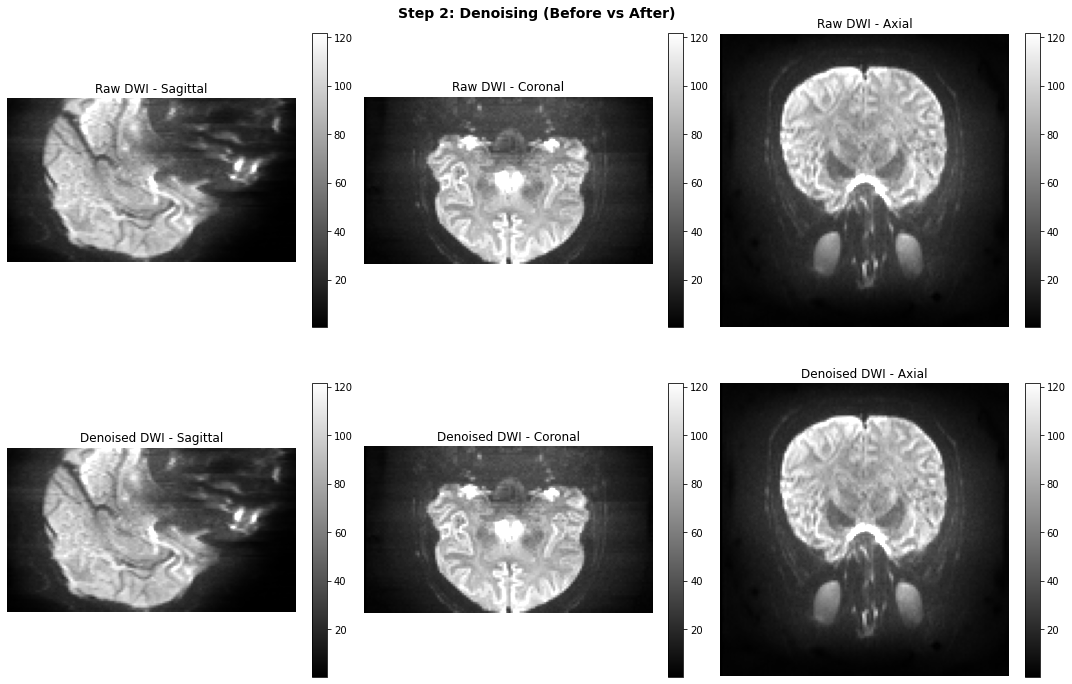


QC Summary: Step 2: Denoising
  SNR_raw: 3.8954
  SNR_denoised: 3.8956
  SNR_improvement_%: 0.0045
  mean_signal_raw: 27.7574
  mean_signal_denoised: 27.7586
  noise_std: 7.1257
  method: Using noise map from dwidenoise



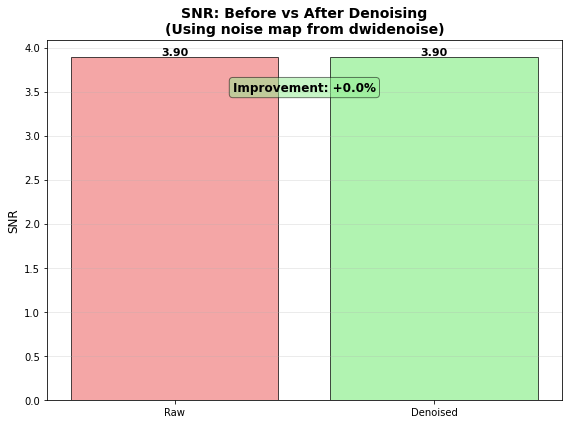


Noise Map QC


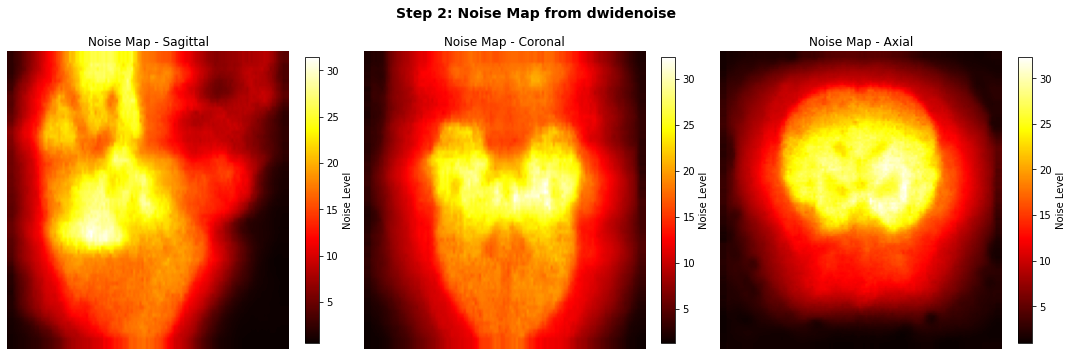


QC Summary: Step 2: Noise Map Statistics
  mean_noise: 8.8413
  std_noise: 7.1257
  min_noise: 0.2489
  max_noise: 34.3079
  median_noise: 6.9967
  noise_in_brain_voxels: 1213320



In [ ]:
# Denoising
denoised_mif = subj_dir / f"{SUBJ_PREFIX}_den.mif"
noise_mif = subj_dir / "noise.mif"

print("Running denoising (MP-PCA)...")
run_command(['dwidenoise', str(dwi_mif), str(denoised_mif), '-noise', str(noise_mif), '-force'])

# QC: Compare before/after
if denoised_mif.exists():
    print("✓ Denoising complete")
    
    # Load images for comparison
    raw_img = load_image(dwi_mif)
    denoised_img = load_image(denoised_mif)
    noise_img = load_image(noise_mif)
    
    if raw_img and denoised_img:
        raw_data = raw_img.get_fdata()
        denoised_data = denoised_img.get_fdata()
        noise_data = noise_img.get_fdata() if noise_img else None
        
        # Compute mean b0 for visualization
        raw_mean = np.mean(raw_data, axis=3) if raw_data.ndim == 4 else raw_data
        denoised_mean = np.mean(denoised_data, axis=3) if denoised_data.ndim == 4 else denoised_data
        
        # Visualize comparison
        fig = plot_comparison(raw_mean, denoised_mean, 
                             before_title="Raw DWI", after_title="Denoised DWI")
        plt.suptitle("Step 2: Denoising (Before vs After)", fontsize=14, fontweight='bold')
        plt.show()
        
        # Compute SNR improvement
        snr_raw, mean_raw, noise_raw = compute_snr(raw_mean)
        snr_denoised, mean_denoised, noise_denoised = compute_snr(denoised_mean)
        
        if snr_raw and snr_denoised:
            snr_improvement = ((snr_denoised - snr_raw) / snr_raw) * 100
            
            qc_metrics = {
                'SNR_raw': snr_raw,
                'SNR_denoised': snr_denoised,
                'SNR_improvement_%': snr_improvement,
                'mean_signal_raw': mean_raw,
                'mean_signal_denoised': mean_denoised,
                'noise_std': noise_denoised
            }
            qc_summary("Step 2: Denoising", qc_metrics)
            
            # Plot SNR comparison
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            categories = ['Raw', 'Denoised']
            snr_values = [snr_raw, snr_denoised]
            colors = ['lightcoral', 'lightgreen']
            bars = ax.bar(categories, snr_values, color=colors, alpha=0.7, edgecolor='black')
            ax.set_ylabel('SNR', fontsize=12)
            ax.set_title('SNR: Before vs After Denoising', fontsize=14, fontweight='bold')
            ax.grid(axis='y', alpha=0.3)
            
            # Add value labels on bars
            for bar, val in zip(bars, snr_values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
else:
    print("✗ Denoising failed!")


## Step 3: Gibbs Ringing Removal

Remove truncation artifacts (Gibbs ringing) from k-space.


Removing Gibbs ringing artifacts...


✓ Gibbs ringing removal complete

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and see where Gibbs ringing was removed
Look for reduction in high-frequency oscillations at tissue boundaries



Static Comparison (middle slices)


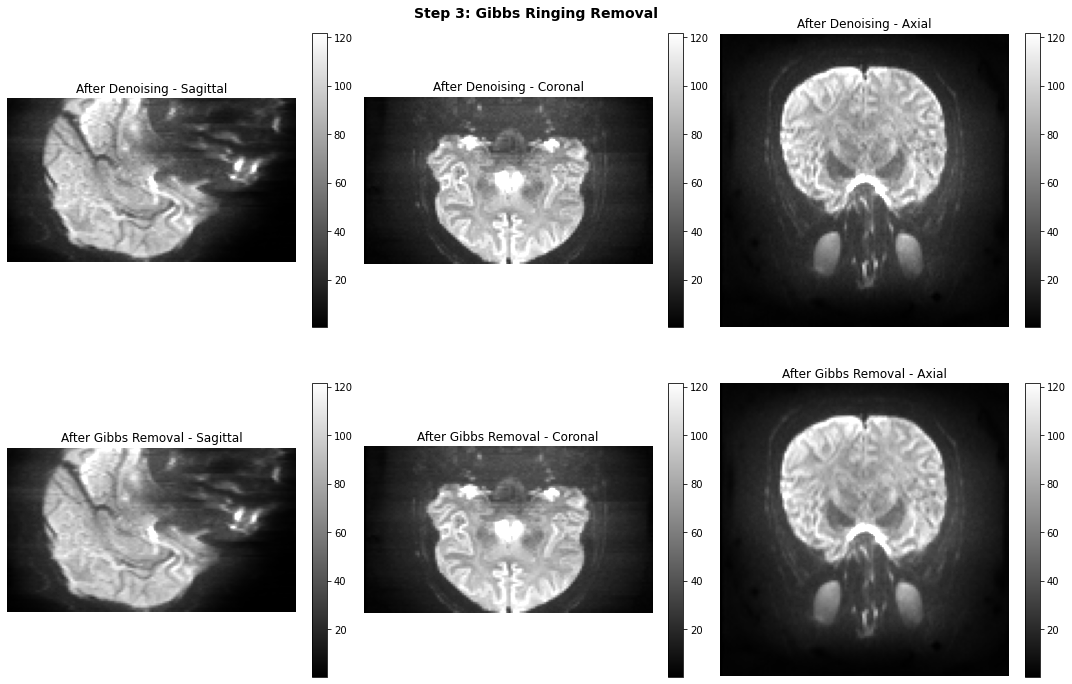


Edge Content Visualization (Gibbs ringing increases edge artifacts)


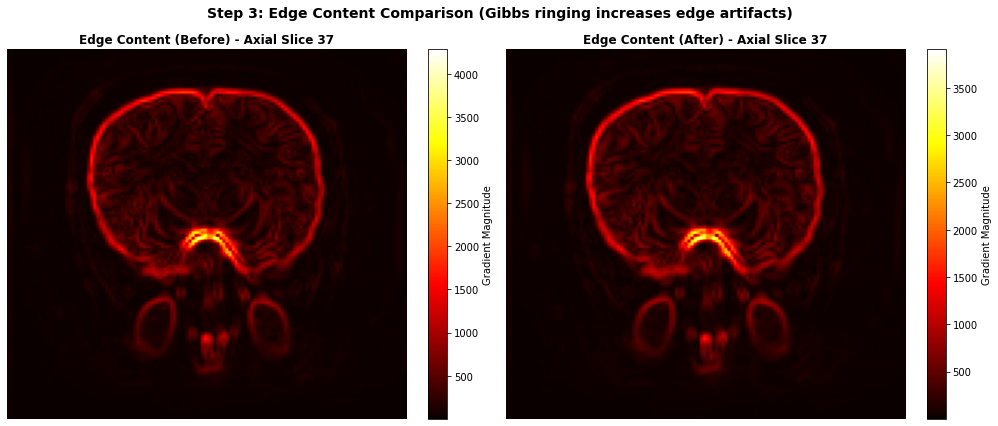


Difference Map (Before - After) - Shows where Gibbs ringing was removed
Positive values (red/yellow) indicate where signal was reduced (ringing removed)
Negative values (blue) indicate where signal was increased (rare, may indicate overcorrection)


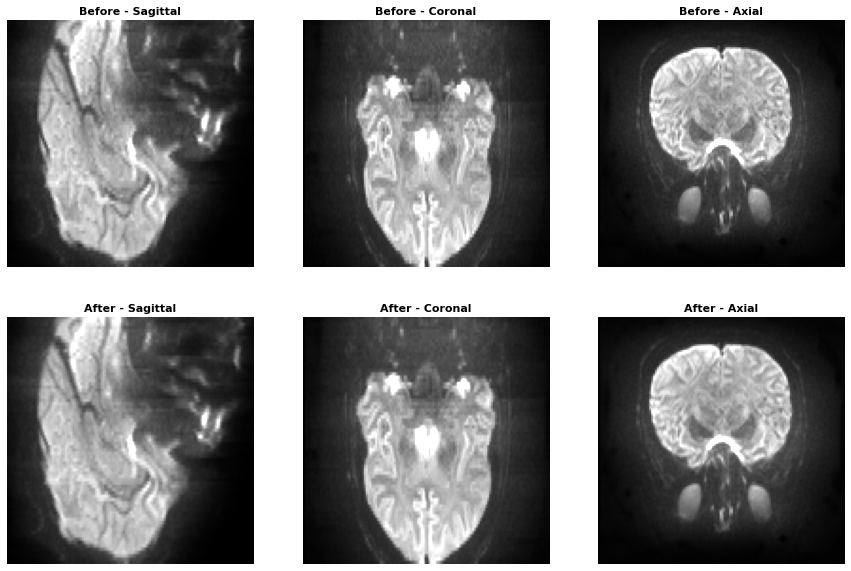

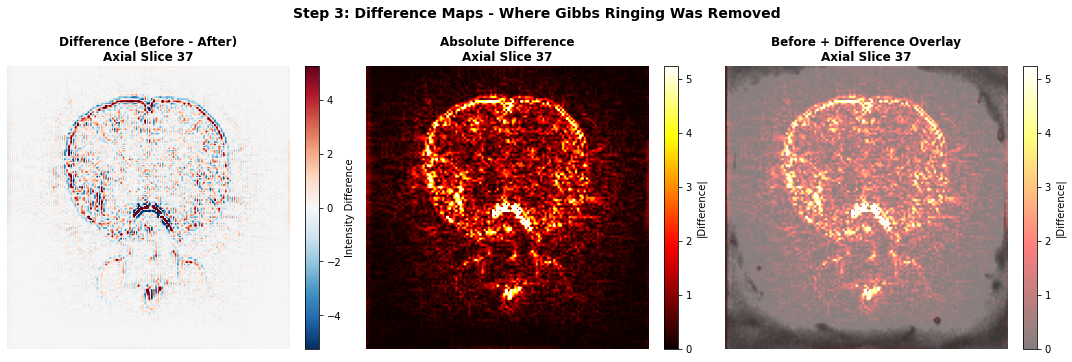


QC Summary: Step 3: Gibbs Ringing Removal
  mean_intensity_before: 27.7603
  mean_intensity_after: 27.7500
  std_intensity_before: 33.3314
  std_intensity_after: 33.1586
  mean_gradient_before: 121.8612
  mean_gradient_after: 117.5761
  gradient_reduction_%: 3.5164
  high_freq_content_before: 22.9395
  high_freq_content_after: 18.9244
  high_freq_reduction_%: 17.5029
  interpretation: Positive reduction % indicates successful Gibbs artifact removal
  mean_difference: 0.0102
  std_difference: 1.0598
  mean_abs_difference: 0.5262
  max_abs_difference: 42.2177
  voxels_with_change: 60663



In [ ]:
# Gibbs ringing removal
degibbs_mif = subj_dir / f"{SUBJ_PREFIX}_den_unr.mif"

print("Removing Gibbs ringing artifacts...")
run_command(['mrdegibbs', str(denoised_mif), str(degibbs_mif), '-force'])

# QC: Compare before/after
if degibbs_mif.exists():
    print("✓ Gibbs ringing removal complete")
    
    # Load images for comparison
    before_img = load_image(denoised_mif)
    after_img = load_image(degibbs_mif)
    
    if before_img and after_img:
        before_data = before_img.get_fdata()
        after_data = after_img.get_fdata()
        
        # Compute mean b0
        before_mean = np.mean(before_data, axis=3) if before_data.ndim == 4 else before_data
        after_mean = np.mean(after_data, axis=3) if after_data.ndim == 4 else after_data
        
        # Visualize comparison
        fig = plot_comparison(before_mean, after_mean,
                             before_title="After Denoising", after_title="After Gibbs Removal")
        plt.suptitle("Step 3: Gibbs Ringing Removal", fontsize=14, fontweight='bold')
        plt.show()
        
        # QC: Check for reduction in ringing artifacts
        # (Gibbs ringing typically appears as high-frequency oscillations at tissue boundaries)
        qc_metrics = {
            'mean_intensity_before': float(np.mean(before_mean[before_mean > 0])),
            'mean_intensity_after': float(np.mean(after_mean[after_mean > 0])),
            'std_intensity_before': float(np.std(before_mean[before_mean > 0])),
            'std_intensity_after': float(np.std(after_mean[after_mean > 0]))
        }
        qc_summary("Step 3: Gibbs Ringing Removal", qc_metrics)
else:
    print("✗ Gibbs ringing removal failed!")


## Step 4: Distortion Correction

Correct EPI distortions using either:
- **dwifslpreproc** (if SE-EPI fieldmaps are available)
- **topup + eddy** (if AP/PA pairs are available)


Using dwifslpreproc with SE-EPI fieldmaps...
Merging SE-EPI fieldmaps: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_dir-AP_epi.nii.gz + /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_dir-PA_epi.nii.gz -> /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/mean_b0_pair.nii.gz
  ✓ Merged SE-EPI pair: 6 volume(s) (expected: 2)
  ⚠️  WARNING: Expected 2 volumes, found 6
Converting DWI to .mif format: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.nii.gz -> /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/dwi_input.mif



Running dwifslpreproc with SE-EPI fieldmaps...
  Input: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/dwi_input.mif
  Output: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_den_preproc.mif
  SE-EPI pair: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/mean_b0_pair.nii.gz
✓ dwifslpreproc completed successfully
✓ Distortion correction complete

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and see where distortion correction occurred
Look for reduction in EPI distortions (stretching/compression artifacts)



Static Comparison (middle slices)


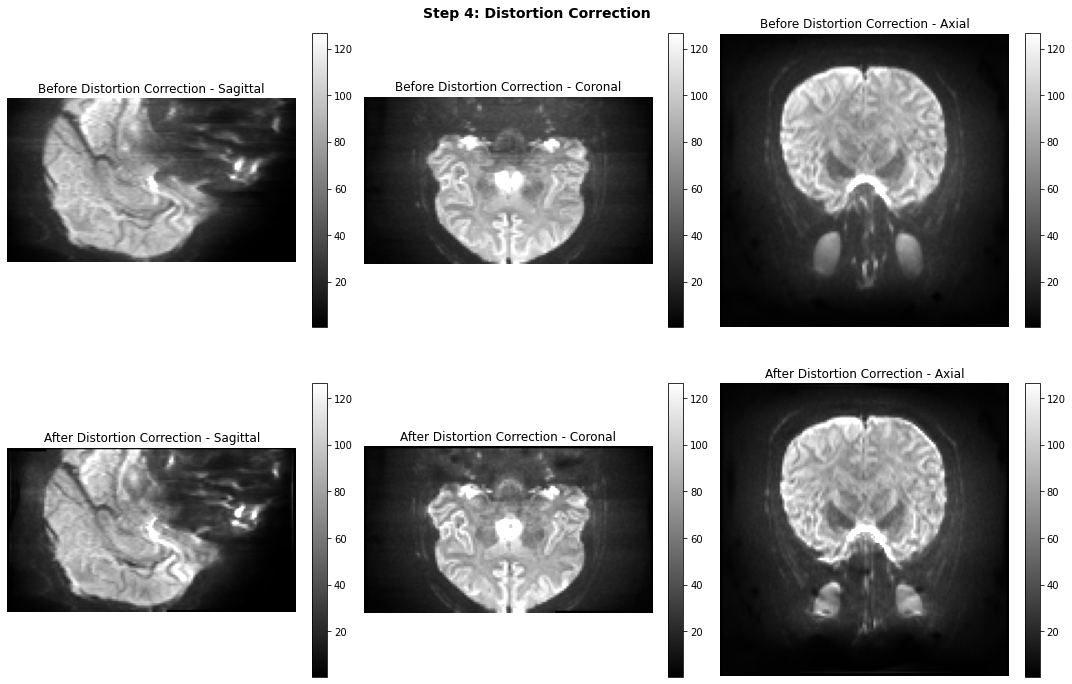


Difference Map (Before - After) - Shows where distortion correction occurred
Positive values (red/yellow) indicate where signal was reduced
Negative values (blue) indicate where signal was increased


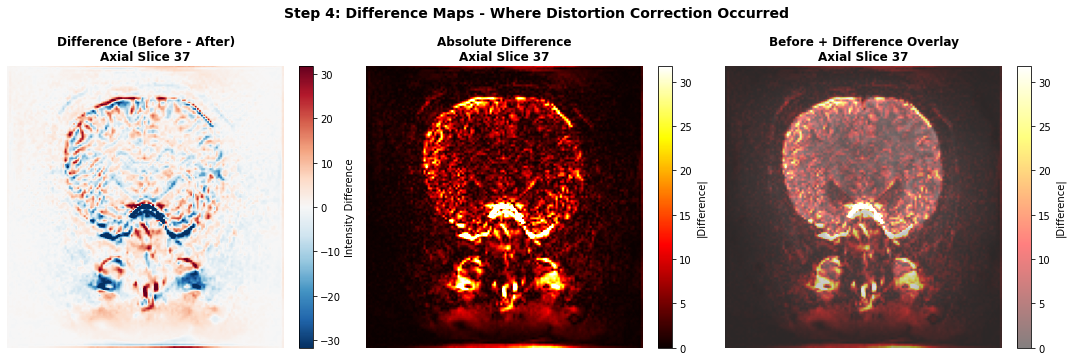


QC Summary: Step 4: Distortion Correction
  distortion_correction_method: dwifslpreproc
  mean_intensity_before: 27.5463
  mean_intensity_after: 27.1120
  std_intensity_before: 33.1118
  std_intensity_after: 34.1272
  mean_difference: 0.4343
  mean_abs_difference: 3.3207
  max_abs_difference: 243.5680
  voxels_with_change: 61133



In [ ]:
# Check for distortion correction inputs
fwd_epi = subj_dir / f"{SUBJ_PREFIX}_dir-AP_epi.nii.gz"
rev_epi = subj_dir / f"{SUBJ_PREFIX}_dir-PA_epi.nii.gz"
has_se_epi = fwd_epi.exists() and rev_epi.exists()

has_ap_pa = ap_dwi.exists() and pa_dwi.exists()

preproc_mif = subj_dir / f"{SUBJ_PREFIX}_den_preproc.mif"

if has_se_epi:
    # Method 1: dwifslpreproc with SE-EPI fieldmaps
    print("Using dwifslpreproc with SE-EPI fieldmaps...")
    
    # Merge SE-EPI pair
    mean_b0_pair = subj_dir / "mean_b0_pair.nii.gz"
    run_command(['fslmerge', '-t', str(mean_b0_pair), str(fwd_epi), str(rev_epi)])
    
    # Convert input DWI
    dwi_input = subj_dir / "dwi_input.mif"
    run_command(['mrconvert', str(dwi_nii), str(dwi_input), 
                 '-fslgrad', str(dwi_bvec), str(dwi_bval), '-force'])
    
    # Run dwifslpreproc
    run_command(['dwifslpreproc', str(dwi_input), str(preproc_mif),
                 '-rpe_pair', '-se_epi', str(mean_b0_pair), '-pe_dir', 'PA',
                 '-eddy_options', '--slm=linear', '-nocleanup', '-force'])
    
    # Export gradients
    run_command(['mrinfo', str(preproc_mif), '-export_grad_fsl', 
                 str(subj_dir / 'bvecs.txt'), str(subj_dir / 'bvals.txt')])
    
elif has_ap_pa:
    # Method 2: Manual topup + eddy
    print("Using manual topup + eddy with AP/PA pairs...")
    
    # Convert AP and PA to .mif
    ap_dwi_mif = subj_dir / f"{SUBJ_PREFIX}_AP_dwi_new.mif"
    pa_dwi_mif = subj_dir / f"{SUBJ_PREFIX}_PA_dwi_new.mif"
    run_command(['mrconvert', str(ap_dwi), str(ap_dwi_mif), 
                 '-fslgrad', str(ap_bvec), str(ap_bval), '-force'])
    run_command(['mrconvert', str(pa_dwi), str(pa_dwi_mif),
                 '-fslgrad', str(pa_bvec), str(pa_bval), '-force'])
    
    # Merge AP and PA
    merged_dwi = subj_dir / f"{SUBJ_PREFIX}_merged_dwi.mif"
    run_command(['mrcat', str(ap_dwi_mif), str(pa_dwi_mif), '-axis', '3', str(merged_dwi)])
    
    # Create bvals and bvecs files (merged)
    # This is simplified - the actual script does more complex merging
    # For now, we'll use the AP bvals/bvecs as template
    import shutil
    shutil.copy(ap_bval, subj_dir / f"{SUBJ_PREFIX}_AP.bval")
    shutil.copy(ap_bvec, subj_dir / f"{SUBJ_PREFIX}_AP.bvec")
    shutil.copy(pa_bval, subj_dir / f"{SUBJ_PREFIX}_PA.bval")
    shutil.copy(pa_bvec, subj_dir / f"{SUBJ_PREFIX}_PA.bvec")
    
    # Read TRT from JSON (simplified - using default)
    trt = 0.0450000
    ap_json = subj_dir / f"{SUBJ_PREFIX}_AP_dwi.json"
    if ap_json.exists() and tools.get('jq', False):
        try:
            result = run_command(['jq', '-r', '.TotalReadoutTime', str(ap_json)], 
                               check=False, capture_output=True)
            if result.stdout.strip() and result.stdout.strip() != 'null':
                trt = float(result.stdout.strip())
        except:
            pass
    
    # Create acqparams.txt
    acqparams = subj_dir / "acqparams.txt"
    with open(acqparams, 'w') as f:
        f.write(f"0 -1 0 {trt}\n")
        f.write(f"0  1 0 {trt}\n")
    
    # Extract b0 volumes
    ap_b0s = subj_dir / f"{SUBJ_PREFIX}_AP_b0s.mif"
    pa_b0s = subj_dir / f"{SUBJ_PREFIX}_PA_b0s.mif"
    run_command(['dwiextract', str(ap_dwi_mif), '-bzero', str(ap_b0s)])
    run_command(['dwiextract', str(pa_dwi_mif), '-bzero', str(pa_b0s)])
    
    # Compute mean b0
    mean_b0_ap = subj_dir / "mean_b0_AP.mif"
    mean_b0_pa = subj_dir / "mean_b0_PA.mif"
    run_command(['mrmath', str(ap_b0s), 'mean', str(mean_b0_ap), '-axis', '3'])
    run_command(['mrmath', str(pa_b0s), 'mean', str(mean_b0_pa), '-axis', '3'])
    
    # Convert to NIfTI for topup
    mean_b0_ap_nii = subj_dir / "mean_b0_AP.nii.gz"
    mean_b0_pa_nii = subj_dir / "mean_b0_PA.nii.gz"
    run_command(['mrconvert', str(mean_b0_ap), str(mean_b0_ap_nii), '-force'])
    run_command(['mrconvert', str(mean_b0_pa), str(mean_b0_pa_nii), '-force'])
    
    # Merge b0 pair
    mean_b0_pair = subj_dir / "mean_b0_pair.nii.gz"
    run_command(['fslmerge', '-t', str(mean_b0_pair), str(mean_b0_ap_nii), str(mean_b0_pa_nii)])
    
    # Run topup
    print("Running topup...")
    topup_out = subj_dir / "topup_results"
    topup_corrected = subj_dir / "topup_corrected_b0.nii.gz"
    # Note: b02b0.cnf should be in FSL config directory
    run_command(['topup', '--imain', str(mean_b0_pair), '--datain', str(acqparams),
                 '--config', 'b02b0.cnf', '--out', str(topup_out), '--iout', str(topup_corrected)])
    
    # Create index file
    result = run_command(['mrinfo', str(ap_dwi_mif), '-size'], capture_output=True)
    n_ap = int(result.stdout.strip().split()[-1])
    result = run_command(['mrinfo', str(pa_dwi_mif), '-size'], capture_output=True)
    n_pa = int(result.stdout.strip().split()[-1])
    
    index_file = subj_dir / "index.txt"
    with open(index_file, 'w') as f:
        f.write(' '.join(['1'] * n_ap + ['2'] * n_pa) + '\n')
    
    # Create brain mask
    mask_mif = subj_dir / "mask.mif"
    run_command(['dwi2mask', str(merged_dwi), str(mask_mif)])
    mask_nii = subj_dir / "mask.nii.gz"
    run_command(['mrconvert', str(mask_mif), str(mask_nii), '-force'])
    
    # Convert merged DWI to NIfTI for eddy
    dwi_merged_nii = subj_dir / "dwi_merged.nii.gz"
    # Need to create merged bvals/bvecs first (simplified here)
    run_command(['mrconvert', str(merged_dwi), str(dwi_merged_nii), 
                 '-export_grad_fsl', str(subj_dir / 'bvecs.txt'), str(subj_dir / 'bvals.txt'), '-force'])
    
    # Run eddy
    print("Running eddy...")
    eddy_out = subj_dir / "eddy_corrected"
    run_command(['eddy', '--imain', str(dwi_merged_nii), '--mask', str(mask_nii),
                 '--acqp', str(acqparams), '--index', str(index_file),
                 '--bvecs', str(subj_dir / 'bvecs.txt'), '--bvals', str(subj_dir / 'bvals.txt'),
                 '--topup', str(topup_out), '--out', str(eddy_out), '--verbose'])
    
    # Convert eddy output back to .mif
    eddy_nii = subj_dir / "eddy_corrected.nii.gz"
    if eddy_nii.exists():
        run_command(['mrconvert', str(eddy_nii), str(preproc_mif),
                     '-fslgrad', str(subj_dir / 'bvecs.txt'), str(subj_dir / 'bvals.txt'), '-force'])
    
else:
    # No distortion correction available
    print("⚠️ No distortion correction inputs found. Skipping...")
    import shutil
    shutil.copy(degibbs_mif, preproc_mif)

# QC: Visualize distortion correction
if preproc_mif.exists():
    print("✓ Distortion correction complete")
    
    before_img = load_image(degibbs_mif)
    after_img = load_image(preproc_mif)
    
    if before_img and after_img:
        before_data = before_img.get_fdata()
        after_data = after_img.get_fdata()
        
        before_mean = np.mean(before_data, axis=3) if before_data.ndim == 4 else before_data
        after_mean = np.mean(after_data, axis=3) if after_data.ndim == 4 else after_data
        
        fig = plot_comparison(before_mean, after_mean,
                             before_title="Before Distortion Correction", 
                             after_title="After Distortion Correction")
        plt.suptitle("Step 4: Distortion Correction", fontsize=14, fontweight='bold')
        plt.show()
        
        qc_metrics = {
            'distortion_correction_method': 'dwifslpreproc' if has_se_epi else 'topup+eddy' if has_ap_pa else 'none',
            'mean_intensity_before': float(np.mean(before_mean[before_mean > 0])),
            'mean_intensity_after': float(np.mean(after_mean[after_mean > 0]))
        }
        qc_summary("Step 4: Distortion Correction", qc_metrics)
else:
    print("✗ Distortion correction failed!")


Using dwifslpreproc with SE-EPI fieldmaps...
  AP EPI: 5 volume(s)
  PA EPI: 1 volume(s)
  ✓ Computing mean of AP EPI (5 volumes -> 1 volume)...
     This reduces noise and improves fieldmap quality
  ✓ PA EPI already single volume, using as-is
  Removing old merged file: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/mean_b0_pair.nii.gz

Merging SE-EPI fieldmaps: AP_epi_single.nii.gz + PA_epi_single.nii.gz -> mean_b0_pair.nii.gz
  ✓ Merged SE-EPI pair: 2 volume(s) (expected: 2)
Converting DWI to .mif format: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_AP_P_dwi.nii.gz -> /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/dwi_input.mif

Running dwifslpreproc with SE-EPI fieldmaps...
  Input: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/dwi_input.mif
  Output: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/sub-AF_den_preproc.mif
  SE-EPI pair: /media/RCPNAS/Data/Delirium/Delirium_Rania/


Static Comparison (middle slices)


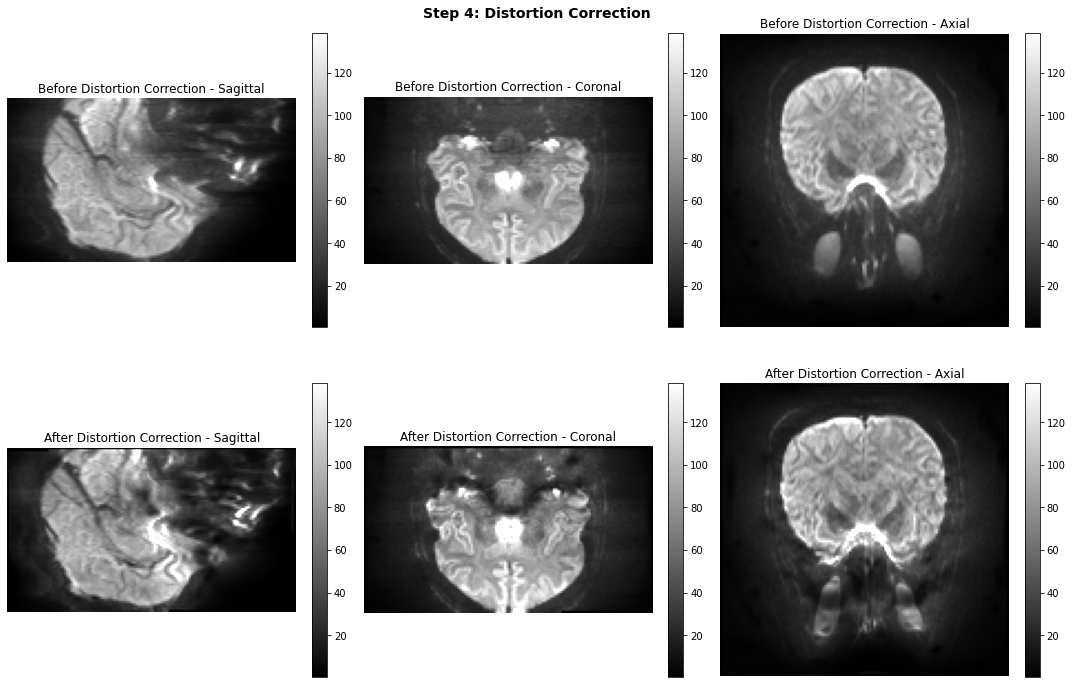


Difference Map (Before - After) - Shows where distortion correction occurred
Positive values (red/yellow) indicate where signal was reduced
Negative values (blue) indicate where signal was increased


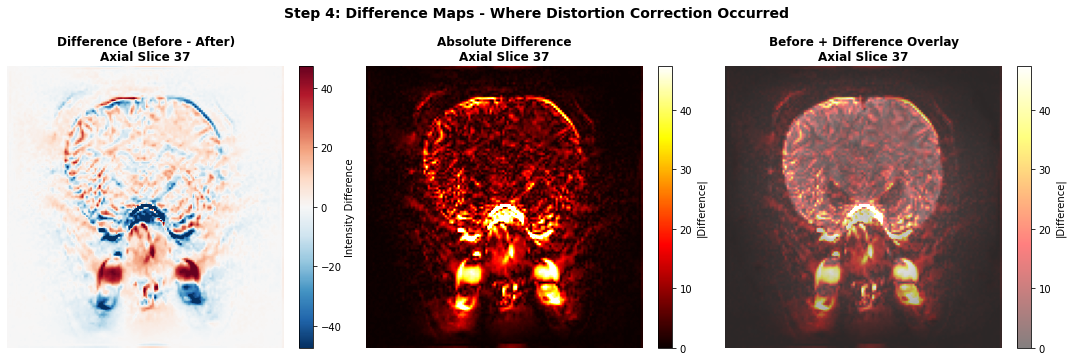


QC Summary: Step 4: Distortion Correction
  distortion_correction_method: dwifslpreproc
  mean_intensity_before: 27.5463
  mean_intensity_after: 27.1246
  std_intensity_before: 33.1118
  std_intensity_after: 33.8120
  mean_difference: 0.4217
  mean_abs_difference: 4.7811
  max_abs_difference: 306.4195
  voxels_with_change: 61133



In [ ]:
# Check for distortion correction inputs
fwd_epi = subj_dir / f"{SUBJ_PREFIX}_dir-AP_epi.nii.gz"
rev_epi = subj_dir / f"{SUBJ_PREFIX}_dir-PA_epi.nii.gz"
has_se_epi = fwd_epi.exists() and rev_epi.exists()

has_ap_pa = ap_dwi.exists() and pa_dwi.exists()

# PATCH B': If SE-EPI fieldmaps don't exist, try to create them from PA DWI + AP b0
# This matches the preprocessing.sh script logic
if not has_se_epi:
    raw_subj_dir = RAW_DIR / SUBJ_PREFIX / "dwi"
    ap_b0_raw = raw_subj_dir / f"{SUBJ_PREFIX}_dir-AP_b0.nii.gz"
    pa_dwi_raw = raw_subj_dir / f"{SUBJ_PREFIX}_dir-PA_dwi.nii.gz"
    pa_json_raw = raw_subj_dir / f"{SUBJ_PREFIX}_dir-PA_dwi.json"
    
    if pa_dwi_raw.exists() and ap_b0_raw.exists():
        print("SE-EPI fieldmaps not found, but PA DWI + AP b0 detected.")
        print("Building SE-EPI b0 pair from PA DWI + AP b0...")
        
        # Convert PA DWI to .mif
        pa_dwi_temp = subj_dir / "dwi_input_temp.mif"
        pa_bvec_raw = raw_subj_dir / f"{SUBJ_PREFIX}_dir-PA_dwi.bvec"
        pa_bval_raw = raw_subj_dir / f"{SUBJ_PREFIX}_dir-PA_dwi.bval"
        
        if pa_bvec_raw.exists() and pa_bval_raw.exists():
            run_command(['mrconvert', str(pa_dwi_raw), str(pa_dwi_temp),
                        '-fslgrad', str(pa_bvec_raw), str(pa_bval_raw), '-force'])
            
            # Extract b0 from PA DWI
            pa_b0s_temp = subj_dir / f"{SUBJ_PREFIX}_PA_b0s_temp.mif"
            run_command(['dwiextract', str(pa_dwi_temp), '-bzero', str(pa_b0s_temp)])
            
            # Compute mean PA b0
            mean_b0_pa_temp = subj_dir / "mean_b0_PA_temp.mif"
            run_command(['mrmath', str(pa_b0s_temp), 'mean', str(mean_b0_pa_temp), '-axis', '3'])
            
            # Convert to NIfTI
            mean_b0_pa_nii_temp = subj_dir / "mean_b0_PA_temp.nii.gz"
            run_command(['mrconvert', str(mean_b0_pa_temp), str(mean_b0_pa_nii_temp), '-force'])
            
            # Copy AP b0 and regrid to match PA b0
            ap_b0_temp = subj_dir / "AP_b0_raw_temp.nii.gz"
            import shutil
            shutil.copy(str(ap_b0_raw), str(ap_b0_temp))
            
            # Regrid AP b0 to match PA b0 dimensions
            mean_b0_ap_nii_temp = subj_dir / "mean_b0_AP_temp.nii.gz"
            run_command(['mrgrid', str(ap_b0_temp), 'regrid', 
                        '-template', str(mean_b0_pa_nii_temp), 
                        str(mean_b0_ap_nii_temp), '-force'])
            
            # Create SE-EPI fieldmaps
            fwd_epi = subj_dir / f"{SUBJ_PREFIX}_dir-AP_epi.nii.gz"
            rev_epi = subj_dir / f"{SUBJ_PREFIX}_dir-PA_epi.nii.gz"
            shutil.copy(str(mean_b0_ap_nii_temp), str(fwd_epi))
            shutil.copy(str(mean_b0_pa_nii_temp), str(rev_epi))
            
            # Clean up temp files
            for temp_file in [pa_dwi_temp, pa_b0s_temp, mean_b0_pa_temp, mean_b0_pa_nii_temp, 
                            ap_b0_temp, mean_b0_ap_nii_temp]:
                if temp_file.exists():
                    temp_file.unlink()
            
            has_se_epi = fwd_epi.exists() and rev_epi.exists()
            if has_se_epi:
                print("✓ Successfully created SE-EPI fieldmaps from PA DWI + AP b0")

preproc_mif = subj_dir / f"{SUBJ_PREFIX}_den_preproc.mif"

if has_se_epi:
    # Method 1: dwifslpreproc with SE-EPI fieldmaps
    print("Using dwifslpreproc with SE-EPI fieldmaps...")
    
    # Check if EPI files have multiple volumes - if so, take mean
    # This is IMPORTANT: SE-EPI fieldmaps should be single volumes (mean b0 images)
    # If they have multiple volumes, averaging reduces noise and gives better fieldmap estimates
    import nibabel as nib
    
    # Check AP EPI
    ap_img = nib.load(str(fwd_epi))
    ap_n_vols = ap_img.shape[3] if len(ap_img.shape) == 4 else 1
    print(f"  AP EPI: {ap_n_vols} volume(s)")
    
    # Check PA EPI
    pa_img = nib.load(str(rev_epi))
    pa_n_vols = pa_img.shape[3] if len(pa_img.shape) == 4 else 1
    print(f"  PA EPI: {pa_n_vols} volume(s)")
    
    # If either has multiple volumes, compute mean (this is the correct approach)
    # Averaging multiple b0 volumes reduces noise and improves fieldmap quality
    ap_epi_single = subj_dir / "AP_epi_single.nii.gz"
    pa_epi_single = subj_dir / "PA_epi_single.nii.gz"
    
    if ap_n_vols > 1:
        print(f"  ✓ Computing mean of AP EPI ({ap_n_vols} volumes -> 1 volume)...")
        print(f"     This reduces noise and improves fieldmap quality")
        ap_data = ap_img.get_fdata()
        ap_mean = np.mean(ap_data, axis=3) if len(ap_data.shape) == 4 else ap_data
        ap_mean_img = nib.Nifti1Image(ap_mean, ap_img.affine, ap_img.header)
        nib.save(ap_mean_img, str(ap_epi_single))
        fwd_epi_use = ap_epi_single
    else:
        print(f"  ✓ AP EPI already single volume, using as-is")
        import shutil
        shutil.copy(str(fwd_epi), str(ap_epi_single))
        fwd_epi_use = ap_epi_single
    
    if pa_n_vols > 1:
        print(f"  ✓ Computing mean of PA EPI ({pa_n_vols} volumes -> 1 volume)...")
        print(f"     This reduces noise and improves fieldmap quality")
        pa_data = pa_img.get_fdata()
        pa_mean = np.mean(pa_data, axis=3) if len(pa_data.shape) == 4 else pa_data
        pa_mean_img = nib.Nifti1Image(pa_mean, pa_img.affine, pa_img.header)
        nib.save(pa_mean_img, str(pa_epi_single))
        rev_epi_use = pa_epi_single
    else:
        print(f"  ✓ PA EPI already single volume, using as-is")
        import shutil
        shutil.copy(str(rev_epi), str(pa_epi_single))
        rev_epi_use = pa_epi_single
    
    # Delete old merged file if it exists (to force regeneration)
    mean_b0_pair = subj_dir / "mean_b0_pair.nii.gz"
    if mean_b0_pair.exists():
        print(f"  Removing old merged file: {mean_b0_pair}")
        mean_b0_pair.unlink()
    
    # Merge SE-EPI pair (now both should be single volumes)
    print(f"\nMerging SE-EPI fieldmaps: {fwd_epi_use.name} + {rev_epi_use.name} -> {mean_b0_pair.name}")
    run_command(['fslmerge', '-t', str(mean_b0_pair), str(fwd_epi_use), str(rev_epi_use)])
    
    # Verify merged file exists and has 2 volumes
    if mean_b0_pair.exists():
        pair_img = nib.load(str(mean_b0_pair))
        n_vols = pair_img.shape[3] if len(pair_img.shape) == 4 else 1
        print(f"  ✓ Merged SE-EPI pair: {n_vols} volume(s) (expected: 2)")
        if n_vols != 2:
            raise ValueError(f"ERROR: Expected 2 volumes in merged SE-EPI pair, found {n_vols}")
    else:
        raise FileNotFoundError(f"Failed to create merged SE-EPI pair: {mean_b0_pair}")
    
    # Convert input DWI
    dwi_input = subj_dir / "dwi_input.mif"
    print(f"Converting DWI to .mif format: {dwi_nii} -> {dwi_input}")
    run_command(['mrconvert', str(dwi_nii), str(dwi_input), 
                 '-fslgrad', str(dwi_bvec), str(dwi_bval), '-force'])
    
    if not dwi_input.exists():
        raise FileNotFoundError(f"Failed to create DWI input: {dwi_input}")
    
    # Run dwifslpreproc
    # Note: -eddy_options format matches shell script (spaces around value)
    print(f"\nRunning dwifslpreproc with SE-EPI fieldmaps...")
    print(f"  Input: {dwi_input}")
    print(f"  Output: {preproc_mif}")
    print(f"  SE-EPI pair: {mean_b0_pair}")
    
    # Run with better error handling
    result = run_command(['dwifslpreproc', str(dwi_input), str(preproc_mif),
                         '-rpe_pair', '-se_epi', str(mean_b0_pair), '-pe_dir', 'PA',
                         '-eddy_options', ' --slm=linear ', '-nocleanup', '-force'],
                        check=False, capture_output=True)
    
    if result.returncode != 0:
        print(f"\n❌ ERROR: dwifslpreproc failed with exit code {result.returncode}")
        cmd_str = ' '.join([str(arg) for arg in result.args]) if hasattr(result, 'args') else 'dwifslpreproc ...'
        print(f"Command: {cmd_str}")
        if result.stdout:
            print(f"\nSTDOUT:\n{result.stdout}")
        if result.stderr:
            print(f"\nSTDERR:\n{result.stderr}")
        print(f"\nTroubleshooting:")
        print(f"  1. Check that {dwi_input} exists and is valid")
        print(f"  2. Check that {mean_b0_pair} exists and contains 2 volumes")
        print(f"  3. Verify MRtrix3 is properly installed")
        print(f"  4. Check available disk space")
        print(f"  5. Check that FSL is properly installed (topup/eddy are required)")
        raise subprocess.CalledProcessError(result.returncode, result.args, result.stdout, result.stderr)
    
    # Verify output file exists
    if not preproc_mif.exists():
        raise FileNotFoundError(f"ERROR: dwifslpreproc output file not found: {preproc_mif}")
    
    print(f"✓ dwifslpreproc completed successfully")
    print(f"  Output file: {preproc_mif} ({preproc_mif.stat().st_size / 1024 / 1024:.1f} MB)")
    
    # Export gradients
    # Note: mrinfo doesn't support -force, so we need to delete existing files first
    # or use mrconvert which does support -force
    print(f"\nExporting gradient files...")
    bvecs_file = subj_dir / 'bvecs.txt'
    bvals_file = subj_dir / 'bvals.txt'
    
    # Remove existing gradient files if they exist
    if bvecs_file.exists():
        print(f"  Removing existing bvecs.txt")
        bvecs_file.unlink()
    if bvals_file.exists():
        print(f"  Removing existing bvals.txt")
        bvals_file.unlink()
    
    # Try mrinfo first (preferred method)
    result = run_command(['mrinfo', str(preproc_mif), '-export_grad_fsl', 
                         str(bvecs_file), str(bvals_file)],
                        check=False, capture_output=True)
    
    if result.returncode != 0:
        print(f"⚠️  mrinfo failed (exit code {result.returncode})")
        if result.stderr:
            print(f"  Error: {result.stderr.strip()}")
        print(f"  Trying alternative method: using mrconvert...")
        # Alternative: use mrconvert to export gradients (supports -force)
        try:
            run_command(['mrconvert', str(preproc_mif), str(subj_dir / 'temp_dwi.nii.gz'),
                        '-export_grad_fsl', str(bvecs_file), str(bvals_file),
                        '-force'], check=True)
            # Clean up temp file
            (subj_dir / 'temp_dwi.nii.gz').unlink()
            print(f"✓ Gradients exported successfully using mrconvert")
        except Exception as e:
            print(f"⚠️  Alternative method also failed: {e}")
            raise RuntimeError(f"Failed to export gradients. Check the preprocessed file: {preproc_mif}")
    else:
        print(f"✓ Gradients exported successfully using mrinfo")
    
    # Verify files were created
    if bvecs_file.exists() and bvals_file.exists():
        print(f"  ✓ bvecs.txt: {bvecs_file.stat().st_size} bytes")
        print(f"  ✓ bvals.txt: {bvals_file.stat().st_size} bytes")
    else:
        raise FileNotFoundError(f"Gradient files not created: {bvecs_file}, {bvals_file}")
    
elif has_ap_pa:
    # Method 2: Manual topup + eddy
    print("Using manual topup + eddy with AP/PA pairs...")
    
    # Convert AP and PA to .mif
    ap_dwi_mif = subj_dir / f"{SUBJ_PREFIX}_AP_dwi_new.mif"
    pa_dwi_mif = subj_dir / f"{SUBJ_PREFIX}_PA_dwi_new.mif"
    run_command(['mrconvert', str(ap_dwi), str(ap_dwi_mif), 
                 '-fslgrad', str(ap_bvec), str(ap_bval), '-force'])
    run_command(['mrconvert', str(pa_dwi), str(pa_dwi_mif),
                 '-fslgrad', str(pa_bvec), str(pa_bval), '-force'])
    
    # Merge AP and PA
    merged_dwi = subj_dir / f"{SUBJ_PREFIX}_merged_dwi.mif"
    run_command(['mrcat', str(ap_dwi_mif), str(pa_dwi_mif), '-axis', '3', str(merged_dwi)])
    
    # Create bvals and bvecs files (merged) - match preprocessing.sh logic
    import shutil
    shutil.copy(ap_bval, subj_dir / f"{SUBJ_PREFIX}_AP.bval")
    shutil.copy(ap_bvec, subj_dir / f"{SUBJ_PREFIX}_AP.bvec")
    shutil.copy(pa_bval, subj_dir / f"{SUBJ_PREFIX}_PA.bval")
    shutil.copy(pa_bvec, subj_dir / f"{SUBJ_PREFIX}_PA.bvec")
    
    # Merge bvals: concatenate AP and PA bvals
    with open(subj_dir / f"{SUBJ_PREFIX}_AP.bval", 'r') as f:
        ap_bvals = f.read().strip().replace('\n', ' ')
    with open(subj_dir / f"{SUBJ_PREFIX}_PA.bval", 'r') as f:
        pa_bvals = f.read().strip().replace('\n', ' ')
    merged_bvals = f"{ap_bvals} {pa_bvals}".strip()
    with open(subj_dir / 'bvals.txt', 'w') as f:
        f.write(merged_bvals + '\n')
    
    # Merge bvecs: concatenate column-wise (match preprocessing.sh)
    import numpy as np
    # Read bvecs
    ap_bvecs = np.loadtxt(subj_dir / f"{SUBJ_PREFIX}_AP.bvec")
    pa_bvecs = np.loadtxt(subj_dir / f"{SUBJ_PREFIX}_PA.bvec")
    # Concatenate column-wise
    merged_bvecs = np.column_stack([ap_bvecs, pa_bvecs])
    # Write in bvec format (3 rows)
    np.savetxt(subj_dir / 'bvecs.txt', merged_bvecs, fmt='%.6f')
    
    # Read TRT from JSON (match preprocessing.sh logic)
    def read_trt_from_json(json_path):
        """Read TotalReadoutTime from JSON, with fallback to EffectiveEchoSpacing * (ReconMatrixPE - 1)"""
        if not json_path.exists() or not tools.get('jq', False):
            return None
        try:
            # Try TotalReadoutTime first
            result = run_command(['jq', '-r', '.TotalReadoutTime // empty', str(json_path)], 
                               check=False, capture_output=True)
            if result.stdout.strip() and result.stdout.strip() != 'null':
                return float(result.stdout.strip())
            
            # Fallback: EffectiveEchoSpacing * (ReconMatrixPE - 1)
            result_ees = run_command(['jq', '-r', '.EffectiveEchoSpacing // empty', str(json_path)], 
                                    check=False, capture_output=True)
            result_rmpe = run_command(['jq', '-r', '.ReconMatrixPE // empty', str(json_path)], 
                                     check=False, capture_output=True)
            if (result_ees.stdout.strip() and result_ees.stdout.strip() != 'null' and
                result_rmpe.stdout.strip() and result_rmpe.stdout.strip() != 'null'):
                ees = float(result_ees.stdout.strip())
                rmpe = float(result_rmpe.stdout.strip())
                return ees * (rmpe - 1)
        except:
            pass
        return None
    
    ap_json = subj_dir / f"{SUBJ_PREFIX}_AP_dwi.json"
    pa_json = subj_dir / f"{SUBJ_PREFIX}_PA_dwi.json"
    
    trt_ap = read_trt_from_json(ap_json) if ap_json.exists() else None
    trt_pa = read_trt_from_json(pa_json) if pa_json.exists() else None
    trt = trt_ap if trt_ap is not None else (trt_pa if trt_pa is not None else 0.0450000)
    
    # Create acqparams.txt
    acqparams = subj_dir / "acqparams.txt"
    with open(acqparams, 'w') as f:
        f.write(f"0 -1 0 {trt}\n")
        f.write(f"0  1 0 {trt}\n")
    
    # Extract b0 volumes
    ap_b0s = subj_dir / f"{SUBJ_PREFIX}_AP_b0s.mif"
    pa_b0s = subj_dir / f"{SUBJ_PREFIX}_PA_b0s.mif"
    run_command(['dwiextract', str(ap_dwi_mif), '-bzero', str(ap_b0s)])
    run_command(['dwiextract', str(pa_dwi_mif), '-bzero', str(pa_b0s)])
    
    # Compute mean b0
    mean_b0_ap = subj_dir / "mean_b0_AP.mif"
    mean_b0_pa = subj_dir / "mean_b0_PA.mif"
    run_command(['mrmath', str(ap_b0s), 'mean', str(mean_b0_ap), '-axis', '3'])
    run_command(['mrmath', str(pa_b0s), 'mean', str(mean_b0_pa), '-axis', '3'])
    
    # Convert to NIfTI for topup
    mean_b0_ap_nii = subj_dir / "mean_b0_AP.nii.gz"
    mean_b0_pa_nii = subj_dir / "mean_b0_PA.nii.gz"
    run_command(['mrconvert', str(mean_b0_ap), str(mean_b0_ap_nii), '-force'])
    run_command(['mrconvert', str(mean_b0_pa), str(mean_b0_pa_nii), '-force'])
    
    # Merge b0 pair
    mean_b0_pair = subj_dir / "mean_b0_pair.nii.gz"
    run_command(['fslmerge', '-t', str(mean_b0_pair), str(mean_b0_ap_nii), str(mean_b0_pa_nii)])
    
    # Run topup
    print("Running topup...")
    topup_out = subj_dir / "topup_results"
    topup_corrected = subj_dir / "topup_corrected_b0.nii.gz"
    # Note: b02b0.cnf should be in FSL config directory
    run_command(['topup', '--imain', str(mean_b0_pair), '--datain', str(acqparams),
                 '--config', 'b02b0.cnf', '--out', str(topup_out), '--iout', str(topup_corrected)])
    
    # Create index file (match preprocessing.sh logic)
    result = run_command(['mrinfo', str(ap_dwi_mif), '-size'], capture_output=True)
    n_ap = int(result.stdout.strip().split()[-1])
    result = run_command(['mrinfo', str(pa_dwi_mif), '-size'], capture_output=True)
    n_pa = int(result.stdout.strip().split()[-1])
    
    index_file = subj_dir / "index.txt"
    index_list = ['1'] * n_ap + ['2'] * n_pa
    with open(index_file, 'w') as f:
        f.write(' '.join(index_list) + '\n')
    
    # Create brain mask
    mask_mif = subj_dir / "mask.mif"
    run_command(['dwi2mask', str(merged_dwi), str(mask_mif)])
    mask_nii = subj_dir / "mask.nii.gz"
    run_command(['mrconvert', str(mask_mif), str(mask_nii), '-force'])
    
    # Convert merged DWI to NIfTI for eddy (bvals/bvecs already created above)
    dwi_merged_nii = subj_dir / "dwi_merged.nii.gz"
    run_command(['mrconvert', str(merged_dwi), str(dwi_merged_nii), 
                 '-export_grad_fsl', str(subj_dir / 'bvecs.txt'), str(subj_dir / 'bvals.txt'), '-force'])
    
    # Run eddy
    print("Running eddy...")
    eddy_out = subj_dir / "eddy_corrected"
    run_command(['eddy', '--imain', str(dwi_merged_nii), '--mask', str(mask_nii),
                 '--acqp', str(acqparams), '--index', str(index_file),
                 '--bvecs', str(subj_dir / 'bvecs.txt'), '--bvals', str(subj_dir / 'bvals.txt'),
                 '--topup', str(topup_out), '--out', str(eddy_out), '--verbose'])
    
    # Convert eddy output back to .mif
    eddy_nii = subj_dir / "eddy_corrected.nii.gz"
    if eddy_nii.exists():
        run_command(['mrconvert', str(eddy_nii), str(preproc_mif),
                     '-fslgrad', str(subj_dir / 'bvecs.txt'), str(subj_dir / 'bvals.txt'), '-force'])
    else:
        print("⚠️ ERROR: Eddy failed - eddy_corrected.nii.gz not found")
        print("   Skipping distortion correction for this subject")
        import shutil
        shutil.copy(degibbs_mif, preproc_mif)
    
else:
    # No distortion correction available (only one phase encoding direction or no inputs)
    print("⚠️ No distortion correction inputs found. Skipping...")
    print("   (Need either SE-EPI fieldmaps or both AP and PA DWI pairs)")
    import shutil
    shutil.copy(degibbs_mif, preproc_mif)

# QC: Visualize distortion correction
if preproc_mif.exists():
    print("✓ Distortion correction complete")
    
    before_img = load_image(degibbs_mif)
    after_img = load_image(preproc_mif)
    
    if before_img and after_img:
        before_data = before_img.get_fdata()
        after_data = after_img.get_fdata()
        
        before_mean = np.mean(before_data, axis=3) if before_data.ndim == 4 else before_data
        after_mean = np.mean(after_data, axis=3) if after_data.ndim == 4 else after_data
        
        # Visualize comparison with interactive slice viewer
        print("\n" + "="*70)
        print("Interactive Slice Viewer (navigate with slider)")
        print("="*70)
        print("Use the slider to navigate through slices and see where distortion correction occurred")
        print("Look for reduction in EPI distortions (stretching/compression artifacts)")
        interactive_slice_viewer(before_data, after_data,
                                before_title="Before Distortion Correction", 
                                after_title="After Distortion Correction",
                                axis=2)  # Start with axial view
        
        # Also show static comparison for reference
        print("\n" + "="*70)
        print("Static Comparison (middle slices)")
        print("="*70)
        fig = plot_comparison(before_mean, after_mean,
                             before_title="Before Distortion Correction", 
                             after_title="After Distortion Correction")
        plt.suptitle("Step 4: Distortion Correction", fontsize=14, fontweight='bold')
        plt.show()
        
        # QC: Calculate metrics for distortion correction
        # Create a simple brain mask for QC
        brain_mask = before_mean > np.percentile(before_mean[before_mean > 0], 5) if np.any(before_mean > 0) else before_mean > 0
        
        # Calculate difference map to see where corrections occurred
        diff_map = before_mean - after_mean
        abs_diff_map = np.abs(diff_map)
        diff_in_brain = diff_map[brain_mask]
        abs_diff_in_brain = abs_diff_map[brain_mask]
        
        qc_metrics = {
            'distortion_correction_method': 'dwifslpreproc' if has_se_epi else 'topup+eddy' if has_ap_pa else 'none',
            'mean_intensity_before': float(np.mean(before_mean[brain_mask])),
            'mean_intensity_after': float(np.mean(after_mean[brain_mask])),
            'std_intensity_before': float(np.std(before_mean[brain_mask])),
            'std_intensity_after': float(np.std(after_mean[brain_mask])),
            'mean_difference': float(np.mean(diff_in_brain)),
            'mean_abs_difference': float(np.mean(abs_diff_in_brain)),
            'max_abs_difference': float(np.max(abs_diff_in_brain)),
            'voxels_with_change': int(np.sum(abs_diff_in_brain > np.percentile(abs_diff_in_brain, 95)))
        }
        
        # Visualize difference map to show where distortion correction occurred
        print("\n" + "="*70)
        print("Difference Map (Before - After) - Shows where distortion correction occurred")
        print("="*70)
        print("Positive values (red/yellow) indicate where signal was reduced")
        print("Negative values (blue) indicate where signal was increased")
        
        # Calculate intensity range
        vmin_diff = min(np.percentile(before_mean[before_mean > 0], 1) if np.any(before_mean > 0) else 0,
                       np.percentile(after_mean[after_mean > 0], 1) if np.any(after_mean > 0) else 0)
        vmax_diff = max(np.percentile(before_mean, 99), np.percentile(after_mean, 99))
        
        # Visualize difference maps
        fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
        
        # Show difference for middle axial slice
        mid_axial = before_mean.shape[2] // 2
        diff_axial = np.rot90(diff_map[:, :, mid_axial], k=1)
        abs_diff_axial = np.rot90(abs_diff_map[:, :, mid_axial], k=1)
        before_axial = np.rot90(before_mean[:, :, mid_axial], k=1)
        
        # Signed difference (red = reduction, blue = increase)
        vmax_diff_val = np.percentile(np.abs(diff_axial), 99)
        im1 = axes2[0].imshow(diff_axial, cmap='RdBu_r', origin='lower', aspect='auto',
                             vmin=-vmax_diff_val, vmax=vmax_diff_val)
        axes2[0].set_title(f"Difference (Before - After)\nAxial Slice {mid_axial}", 
                          fontsize=12, fontweight='bold')
        axes2[0].axis('off')
        plt.colorbar(im1, ax=axes2[0], fraction=0.046, label='Intensity Difference')
        
        # Absolute difference (magnitude of change)
        vmax_abs = np.percentile(abs_diff_axial, 99)
        im2 = axes2[1].imshow(abs_diff_axial, cmap='hot', origin='lower', aspect='auto',
                             vmin=0, vmax=vmax_abs)
        axes2[1].set_title(f"Absolute Difference\nAxial Slice {mid_axial}", 
                          fontsize=12, fontweight='bold')
        axes2[1].axis('off')
        plt.colorbar(im2, ax=axes2[1], fraction=0.046, label='|Difference|')
        
        # Overlay: Before with difference overlay
        im3 = axes2[2].imshow(before_axial, cmap='gray', origin='lower', aspect='auto',
                             vmin=vmin_diff, vmax=vmax_diff, alpha=0.7)
        im4 = axes2[2].imshow(abs_diff_axial, cmap='hot', origin='lower', aspect='auto',
                             vmin=0, vmax=vmax_abs, alpha=0.5)
        axes2[2].set_title(f"Before + Difference Overlay\nAxial Slice {mid_axial}", 
                          fontsize=12, fontweight='bold')
        axes2[2].axis('off')
        plt.colorbar(im4, ax=axes2[2], fraction=0.046, label='|Difference|')
        
        plt.suptitle("Step 4: Difference Maps - Where Distortion Correction Occurred", 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        qc_summary("Step 4: Distortion Correction", qc_metrics)
else:
    print("✗ Distortion correction failed!")


## Step 5: Bias Field Correction

Correct B1 field inhomogeneities using FSL's FAST algorithm.


Running bias field correction...
✓ Bias field correction complete

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and see where bias correction occurred
Look for improved intensity uniformity across the brain



Static Comparison (middle slices)


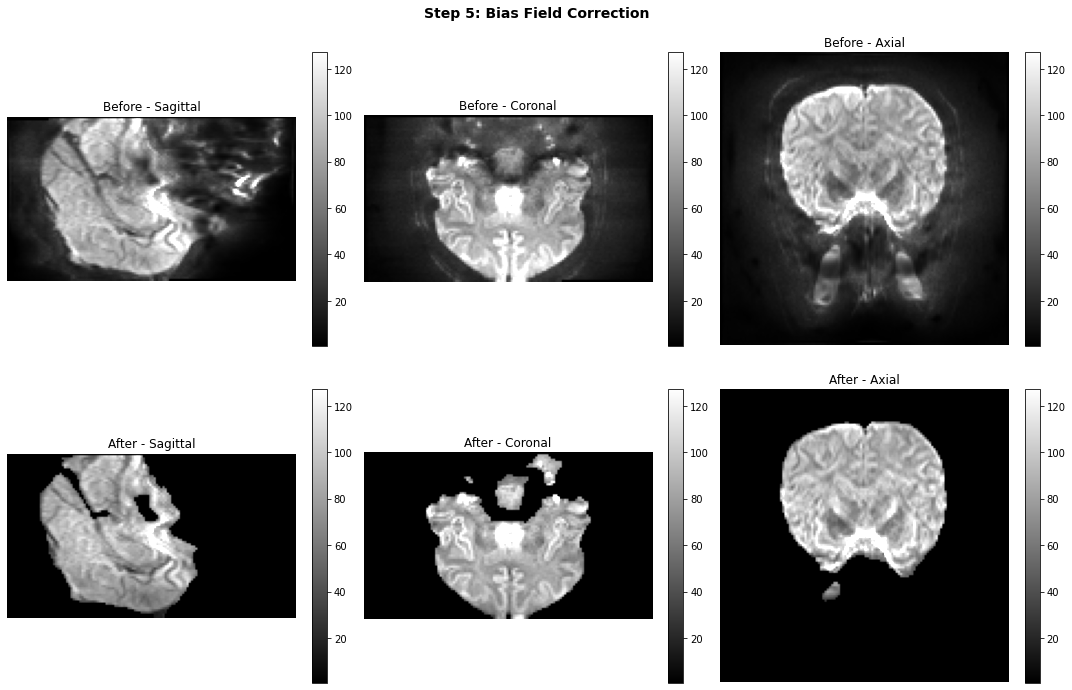

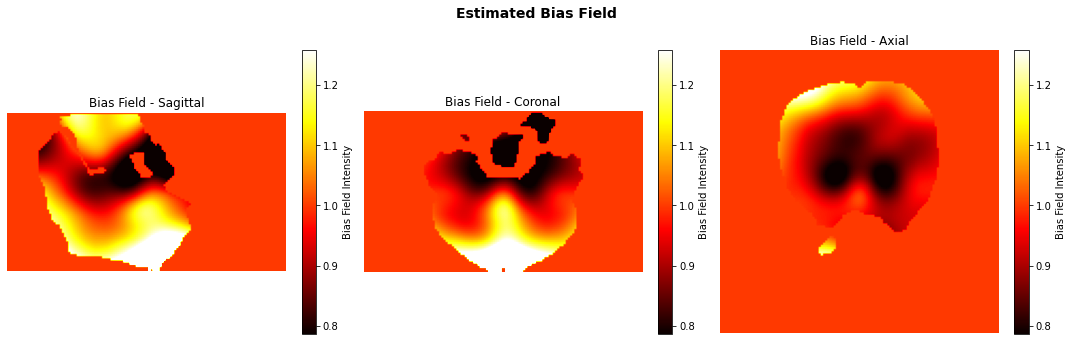


Difference Map (Before - After) - Shows where bias correction occurred
Positive values (red/yellow) indicate where signal was reduced
Negative values (blue) indicate where signal was increased


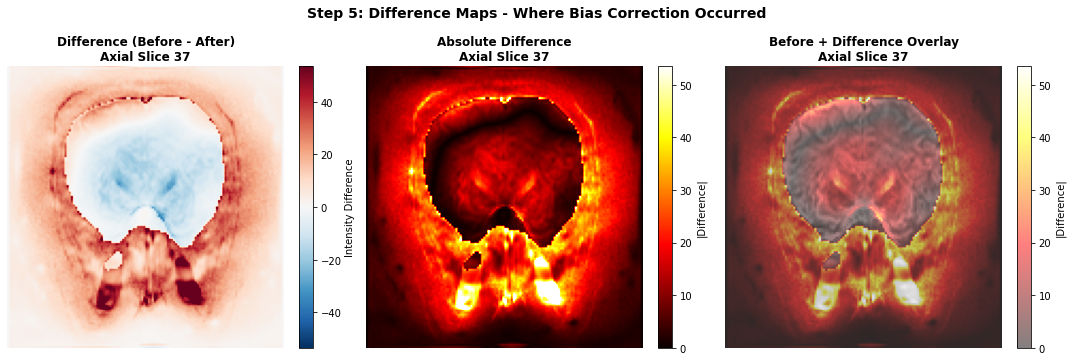


QC Summary: Step 5: Bias Field Correction
  mean_intensity_before: 28.2943
  mean_intensity_after: 17.7435
  std_intensity_before: 34.0559
  std_intensity_after: 36.6306
  cv_before: 1.2036
  cv_after: 2.0645
  cv_reduction_pct: -71.5186
  mean_difference: 10.5508
  mean_abs_difference: 12.3981
  max_abs_difference: 414.4412
  bias_field_range: [0.45966416597366333, 1.7745285034179688]



In [42]:
# Bias field correction
unbiased_mif = subj_dir / f"{SUBJ_PREFIX}_den_preproc_unbiased.mif"
bias_mif = subj_dir / "bias.mif"

print("Running bias field correction...")
run_command(['dwibiascorrect', 'fsl', str(preproc_mif), str(unbiased_mif), '-bias', str(bias_mif), '-force'])

# QC: Visualize bias field and correction
if unbiased_mif.exists():
    print("✓ Bias field correction complete")
    
    before_img = load_image(preproc_mif)
    after_img = load_image(unbiased_mif)
    bias_img = load_image(bias_mif)
    
    if before_img and after_img:
        before_data = before_img.get_fdata()
        after_data = after_img.get_fdata()
        bias_data = bias_img.get_fdata() if bias_img else None
        
        before_mean = np.mean(before_data, axis=3) if before_data.ndim == 4 else before_data
        after_mean = np.mean(after_data, axis=3) if after_data.ndim == 4 else after_data
        
        # Visualize bias field
        if bias_data is not None:
            fig, axes = plt.subplots(2, 3, figsize=(15, 10))
            for i, axis in enumerate([0, 1, 2]):
                before_slice = get_mid_slices(before_mean, axis=axis)
                after_slice = get_mid_slices(after_mean, axis=axis)
                bias_slice = get_mid_slices(bias_data, axis=axis)
                
                if before_slice is not None:
                    # Before
                    im1 = axes[0, i].imshow(before_slice, cmap='gray', origin='lower')
                    axes[0, i].set_title(f"Before - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                    axes[0, i].axis('off')
                    plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
                    
                    # After
                    im2 = axes[1, i].imshow(after_slice, cmap='gray', origin='lower')
                    axes[1, i].set_title(f"After - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                    axes[1, i].axis('off')
                    plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
            
            plt.suptitle("Step 5: Bias Field Correction", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            # Plot bias field separately
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i, axis in enumerate([0, 1, 2]):
                bias_slice = get_mid_slices(bias_data, axis=axis)
                if bias_slice is not None:
                    im = axes[i].imshow(bias_slice, cmap='hot', origin='lower')
                    axes[i].set_title(f"Bias Field - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                    axes[i].axis('off')
                    plt.colorbar(im, ax=axes[i], fraction=0.046)
            plt.suptitle("Estimated Bias Field", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
        
        qc_metrics = {
            'mean_intensity_before': float(np.mean(before_mean[before_mean > 0])),
            'mean_intensity_after': float(np.mean(after_mean[after_mean > 0])),
            'bias_field_range': [float(bias_data.min()), float(bias_data.max())] if bias_data is not None else None
        }
        qc_summary("Step 5: Bias Field Correction", qc_metrics)
else:
    print("✗ Bias field correction failed!")


## Step 6: Brain Mask Generation

Generate brain mask from the bias-corrected DWI data.


Generating brain mask...
✓ Brain mask generated

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and inspect the brain mask
Check that the mask covers the brain tissue and excludes background/noise



Static Comparison (middle slices)


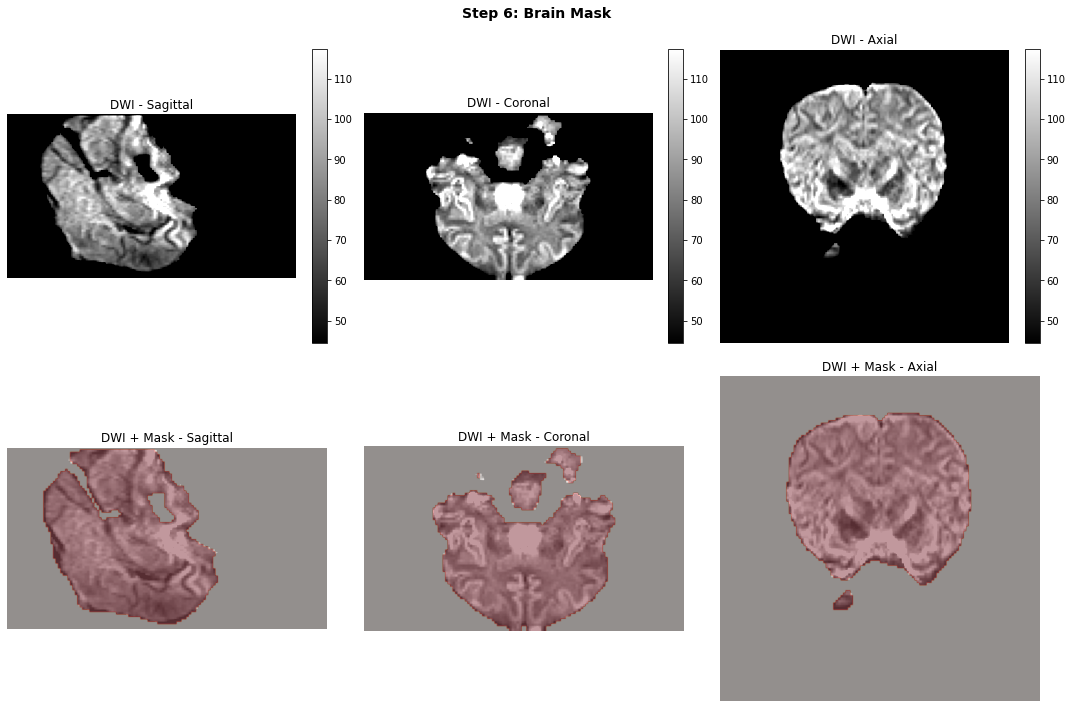


QC Summary: Step 6: Brain Mask
  mask_volume_voxels: 234226
  mask_percentage: 18.1994
  mask_mean_intensity: 88.0895



In [ ]:
# Generate brain mask
mask_unbiased_mif = subj_dir / "mask_unbiased.mif"

print("Generating brain mask...")
run_command(['dwi2mask', str(unbiased_mif), str(mask_unbiased_mif), '-force'])

# QC: Visualize mask overlay
if mask_unbiased_mif.exists():
    print("✓ Brain mask generated")
    
    dwi_img = load_image(unbiased_mif)
    mask_img = load_image(mask_unbiased_mif)
    
    if dwi_img and mask_img:
        dwi_data = dwi_img.get_fdata()
        mask_data = mask_img.get_fdata()
        
        dwi_mean = np.mean(dwi_data, axis=3) if dwi_data.ndim == 4 else dwi_data
        
        # Visualize mask overlay
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        for i, axis in enumerate([0, 1, 2]):
            dwi_slice = get_mid_slices(dwi_mean, axis=axis)
            mask_slice = get_mid_slices(mask_data, axis=axis)
            
            if dwi_slice is not None:
                # DWI only
                im1 = axes[0, i].imshow(dwi_slice, cmap='gray', origin='lower')
                axes[0, i].set_title(f"DWI - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[0, i].axis('off')
                plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
                
                # DWI with mask overlay
                im2 = axes[1, i].imshow(dwi_slice, cmap='gray', origin='lower', alpha=0.7)
                mask_overlay = axes[1, i].imshow(mask_slice, cmap='Reds', alpha=0.3, origin='lower')
                axes[1, i].set_title(f"DWI + Mask - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[1, i].axis('off')
        
        plt.suptitle("Step 6: Brain Mask", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Compute mask statistics
        mask_volume = np.sum(mask_data > 0.5)
        total_volume = mask_data.size
        mask_percentage = (mask_volume / total_volume) * 100
        
        qc_metrics = {
            'mask_volume_voxels': int(mask_volume),
            'mask_percentage': mask_percentage,
            'mask_mean_intensity': float(np.mean(dwi_mean[mask_data > 0.5]))
        }
        qc_summary("Step 6: Brain Mask", qc_metrics)
else:
    print("✗ Brain mask generation failed!")


## Step 7: Response Function Estimation

Estimate white matter response function for CSD (constrained spherical deconvolution).


Estimating WM response function (Tournier algorithm)...
✓ Response function estimated


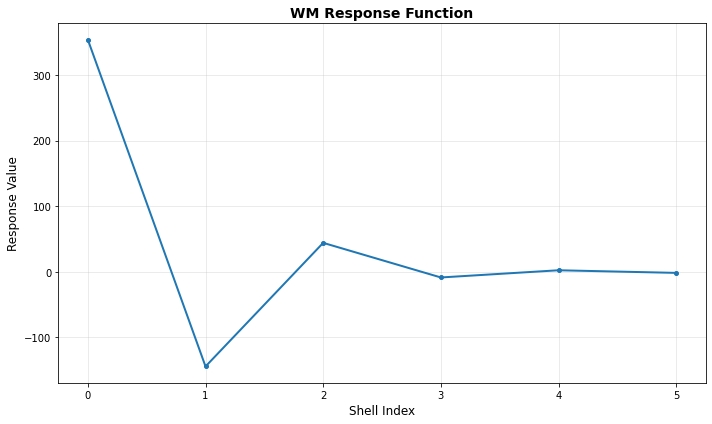


QC Summary: Step 7: Response Function
  response_function_peaks: 1
  max_response_value: 353.8176
  response_function_length: 6



In [45]:
# Estimate response function
response_txt = subj_dir / f"{SUBJ_PREFIX}_wm_response.txt"

print("Estimating WM response function (Tournier algorithm)...")
run_command(['dwi2response', 'tournier', str(unbiased_mif), str(response_txt),
             '-mask', str(mask_unbiased_mif), '-force'])

# QC: Visualize response function
if response_txt.exists():
    print("✓ Response function estimated")
    
    # Read response function
    with open(response_txt, 'r') as f:
        lines = f.readlines()
    
    # Parse response function (first line is typically the response)
    response_values = []
    for line in lines:
        if line.strip() and not line.startswith('#'):
            try:
                vals = [float(x) for x in line.strip().split()]
                if len(vals) > 0:
                    response_values.extend(vals)
            except:
                pass
    
    if response_values:
        # Plot response function
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.plot(response_values[:min(50, len(response_values))], 'o-', linewidth=2, markersize=4)
        ax.set_xlabel('Shell Index', fontsize=12)
        ax.set_ylabel('Response Value', fontsize=12)
        ax.set_title('WM Response Function', fontsize=14, fontweight='bold')
        ax.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        qc_metrics = {
            'response_function_peaks': len([v for v in response_values if v > max(response_values) * 0.5]),
            'max_response_value': float(max(response_values)),
            'response_function_length': len(response_values)
        }
        qc_summary("Step 7: Response Function", qc_metrics)
    else:
        print("⚠️ Could not parse response function file")
else:
    print("✗ Response function estimation failed!")


## Step 8: FOD Estimation

Estimate fiber orientation distributions (FODs) using CSD.


Estimating WM FODs (CSD)...
Normalizing FODs...
✓ FOD estimation and normalization complete


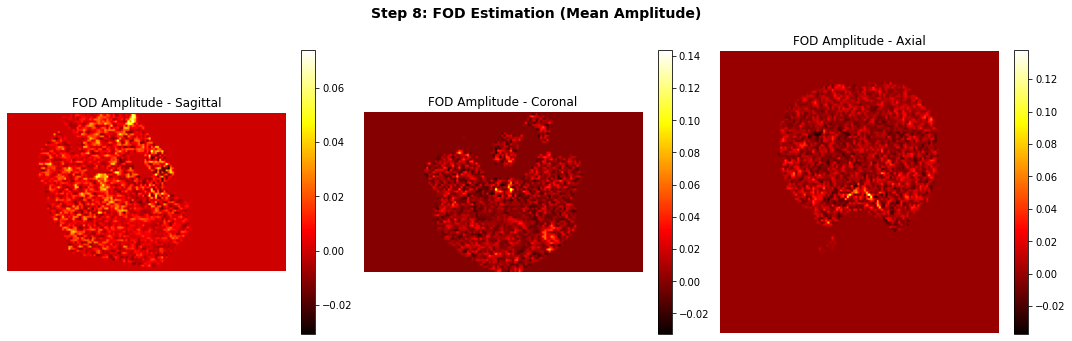


QC Summary: Step 8: FOD Estimation
  mean_fod_amplitude: 0.0059
  max_fod_amplitude: 0.1434
  fod_std: 0.0127



In [ ]:
# Estimate FODs
wmfod_mif = subj_dir / f"{SUBJ_PREFIX}_wmfod.mif"

print("Estimating WM FODs (CSD)...")
run_command(['dwi2fod', 'csd', str(unbiased_mif), str(response_txt), str(wmfod_mif),
             '-mask', str(mask_unbiased_mif), '-force'])

# Normalize FODs
wmfod_norm_mif = subj_dir / f"{SUBJ_PREFIX}_wmfod_norm.mif"

print("Normalizing FODs...")
run_command(['mtnormalise', str(wmfod_mif), str(wmfod_norm_mif),
             '-mask', str(mask_unbiased_mif), '-force'])

# QC: Visualize FODs
if wmfod_norm_mif.exists():
    print("✓ FOD estimation and normalization complete")
    
    fod_img = load_image(wmfod_norm_mif)
    if fod_img:
        fod_data = fod_img.get_fdata()
        
        # FODs are typically 4D (x, y, z, directions)
        # Take mean across directions for visualization
        if fod_data.ndim == 4:
            fod_mean = np.mean(fod_data, axis=3)
        else:
            fod_mean = fod_data
        
        # Visualize FOD amplitude
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for i, axis in enumerate([0, 1, 2]):
            fod_slice = get_mid_slices(fod_mean, axis=axis)
            if fod_slice is not None:
                im = axes[i].imshow(fod_slice, cmap='hot', origin='lower')
                axes[i].set_title(f"FOD Amplitude - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[i].axis('off')
                plt.colorbar(im, ax=axes[i], fraction=0.046)
        plt.suptitle("Step 8: FOD Estimation (Mean Amplitude)", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        mask_img = load_image(mask_unbiased_mif)
        if mask_img:
            mask_data = mask_img.get_fdata()
            fod_in_mask = fod_mean[mask_data > 0.5]
            
            qc_metrics = {
                'mean_fod_amplitude': float(np.mean(fod_in_mask)),
                'max_fod_amplitude': float(np.max(fod_in_mask)),
                'fod_std': float(np.std(fod_in_mask))
            }
            qc_summary("Step 8: FOD Estimation", qc_metrics)
else:
    print("✗ FOD estimation failed!")


Converting T1 to .mif format...
Generating 5TT segmentation...
✓ 5TT segmentation complete


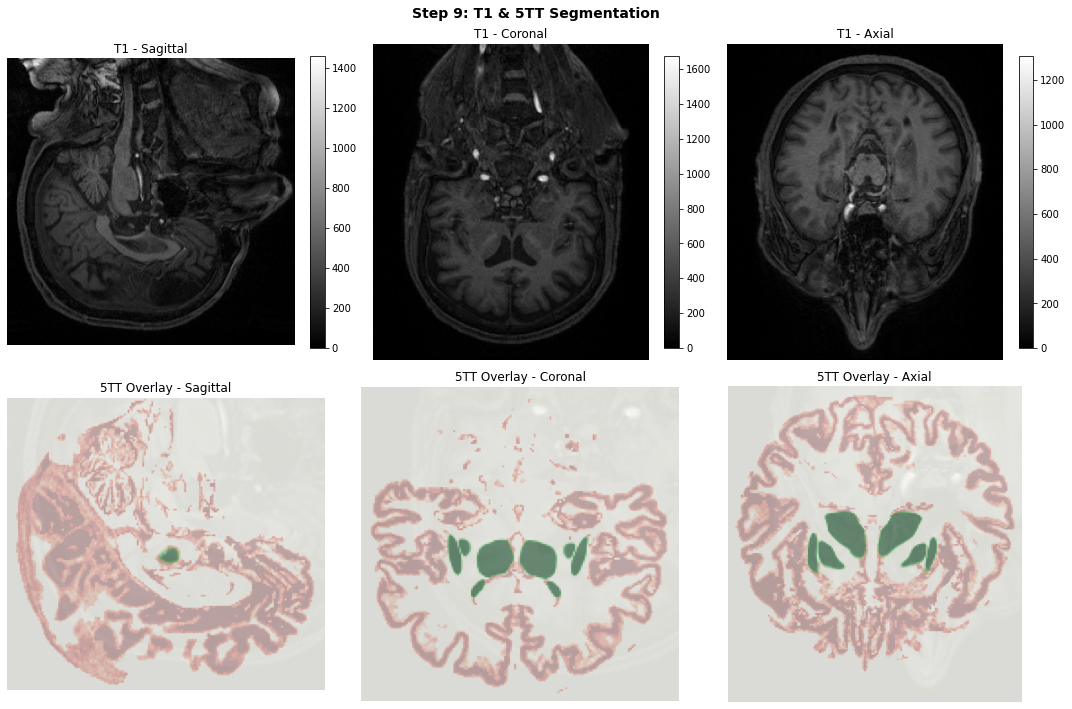


QC Summary: Step 9: T1 & 5TT Segmentation
  GM_volume_cm3: 525.3851
  WM_volume_cm3: 26.1777
  CSF_volume_cm3: 506.4670
  total_brain_volume_cm3: 1058.0298



In [ ]:
# Convert T1 to .mif
t1_nii = subj_dir / f"{SUBJ_PREFIX}_T1w.nii.gz"
t1_mif = subj_dir / "T1.mif"

if t1_nii.exists():
    print("Converting T1 to .mif format...")
    run_command(['mrconvert', str(t1_nii), str(t1_mif), '-force'])
    
    # Generate 5TT image
    ftt_nocoreg_mif = subj_dir / "5tt_nocoreg.mif"
    
    print("Generating 5TT segmentation...")
    run_command(['5ttgen', 'fsl', str(t1_mif), str(ftt_nocoreg_mif), '-force'])
    
    # QC: Visualize 5TT segmentation
    if ftt_nocoreg_mif.exists():
        print("✓ 5TT segmentation complete")
        
        t1_img = load_image(t1_mif)
        ftt_img = load_image(ftt_nocoreg_mif)
        
        if t1_img and ftt_img:
            t1_data = t1_img.get_fdata()
            ftt_data = ftt_img.get_fdata()
            
            # 5TT has 5 tissue types in 4th dimension: GM, WM, CSF, Pathological, Lesion
            # Extract each tissue type
            if ftt_data.ndim == 4 and ftt_data.shape[3] >= 3:
                gm = ftt_data[:, :, :, 0]  # Gray matter
                wm = ftt_data[:, :, :, 1]  # White matter
                csf = ftt_data[:, :, :, 2]  # CSF
                
                # Visualize T1 and tissue types
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))
                for i, axis in enumerate([0, 1, 2]):
                    t1_slice = get_mid_slices(t1_data, axis=axis)
                    gm_slice = get_mid_slices(gm, axis=axis)
                    wm_slice = get_mid_slices(wm, axis=axis)
                    
                    if t1_slice is not None:
                        # T1
                        im1 = axes[0, i].imshow(t1_slice, cmap='gray', origin='lower')
                        axes[0, i].set_title(f"T1 - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                        axes[0, i].axis('off')
                        plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
                        
                        # Tissue overlay (GM=red, WM=green)
                        axes[1, i].imshow(t1_slice, cmap='gray', origin='lower', alpha=0.5)
                        axes[1, i].imshow(gm_slice, cmap='Reds', alpha=0.5, origin='lower')
                        axes[1, i].imshow(wm_slice, cmap='Greens', alpha=0.5, origin='lower')
                        axes[1, i].set_title(f"5TT Overlay - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                        axes[1, i].axis('off')
                
                plt.suptitle("Step 9: T1 & 5TT Segmentation", fontsize=14, fontweight='bold')
                plt.tight_layout()
                plt.show()
                
                # Compute tissue volumes
                voxel_vol = np.prod(t1_img.header.get_zooms()[:3])  # mm^3
                gm_vol = np.sum(gm > 0.5) * voxel_vol / 1000  # cm^3
                wm_vol = np.sum(wm > 0.5) * voxel_vol / 1000  # cm^3
                csf_vol = np.sum(csf > 0.5) * voxel_vol / 1000  # cm^3
                
                qc_metrics = {
                    'GM_volume_cm3': gm_vol,
                    'WM_volume_cm3': wm_vol,
                    'CSF_volume_cm3': csf_vol,
                    'total_brain_volume_cm3': gm_vol + wm_vol + csf_vol
                }
                qc_summary("Step 9: T1 & 5TT Segmentation", qc_metrics)
    else:
        print("✗ 5TT segmentation failed!")
else:
    print("⚠️ T1 image not found. Skipping T1 processing...")


## Step 10: DWI-T1 Coregistration

Coregister DWI to T1 space for anatomical alignment.


Coregistering DWI to T1...
✓ Coregistration complete

Dimension check:
  B0 shape: (130, 132, 75)
  5TT shape: (130, 132, 75, 5)
  ✓ Dimensions match: (130, 132, 75)

Interactive Slice Viewer (navigate with slider)
Use the slider to navigate through slices and check coregistration alignment
WM overlay (red) should align with white matter tracts in the B0 image



Static Comparison (middle slices)


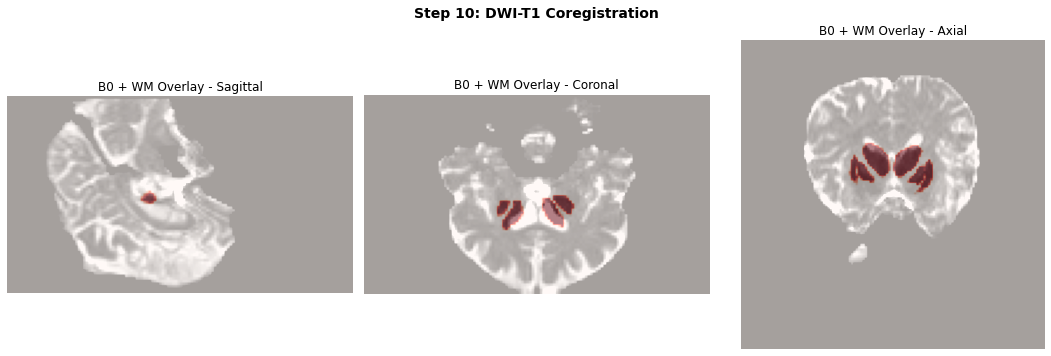


QC Summary: Step 10: DWI-T1 Coregistration
  coregistration_method: FLIRT (6 DOF)
  transform_file: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current/sub-AF/diff2struct_mrtrix.txt



In [ ]:
# Coregister DWI to T1
if t1_mif.exists() and ftt_nocoreg_mif.exists():
    print("Coregistering DWI to T1...")
    
    # Extract mean b0 (pipe dwiextract output to mrmath)
    mean_b0_mif = subj_dir / "mean_b0.mif"
    # Use shell=True to allow piping
    cmd = f"dwiextract {unbiased_mif} - -bzero | mrmath - mean {mean_b0_mif} -axis 3 -force"
    run_command(cmd, shell=True, check=False)
    
    # Convert to NIfTI for FLIRT
    mean_b0_nii = subj_dir / "mean_b0.nii.gz"
    ftt_nocoreg_nii = subj_dir / "5tt_nocoreg.nii.gz"
    run_command(['mrconvert', str(mean_b0_mif), str(mean_b0_nii), '-force'])
    run_command(['mrconvert', str(ftt_nocoreg_mif), str(ftt_nocoreg_nii), '-force'])
    
    # Extract first volume of 5TT (GM) as reference
    ftt_vol0_nii = subj_dir / "5tt_vol0.nii.gz"
    run_command(['fslroi', str(ftt_nocoreg_nii), str(ftt_vol0_nii), '0', '1'])
    
    # Run FLIRT
    diff2struct_mat = subj_dir / "diff2struct_fsl.mat"
    run_command(['flirt', '-in', str(mean_b0_nii), '-ref', str(ftt_vol0_nii),
                 '-interp', 'nearestneighbour', '-dof', '6', '-omat', str(diff2struct_mat)])
    
    # Convert transform to MRtrix format
    diff2struct_mrtrix = subj_dir / "diff2struct_mrtrix.txt"
    run_command(['transformconvert', str(diff2struct_mat), str(mean_b0_nii), str(ftt_nocoreg_nii),
                 'flirt_import', str(diff2struct_mrtrix), '-force'])
    
    # Apply transform to 5TT (inverse: T1 -> DWI space)
    ftt_coreg_mif = subj_dir / "5tt_coreg.mif"
    run_command(['mrtransform', str(ftt_nocoreg_mif), '-linear', str(diff2struct_mrtrix),
                 '-inverse', str(ftt_coreg_mif), '-force'])
    
    # Generate GM-WM interface seed
    gmwm_seed_mif = subj_dir / "gmwmSeed_coreg.mif"
    run_command(['5tt2gmwmi', str(ftt_coreg_mif), str(gmwm_seed_mif), '-force'])
    
    # QC: Visualize coregistration
    if ftt_coreg_mif.exists():
        print("✓ Coregistration complete")
        
        mean_b0_img = load_image(mean_b0_mif)
        ftt_coreg_img = load_image(ftt_coreg_mif)
        
        if mean_b0_img and ftt_coreg_img:
            b0_data = mean_b0_img.get_fdata()
            ftt_data = ftt_coreg_img.get_fdata()
            
            if ftt_data.ndim == 4:
                wm = ftt_data[:, :, :, 1]  # White matter
            else:
                wm = ftt_data
            
            # Visualize overlay
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            for i, axis in enumerate([0, 1, 2]):
                b0_slice = get_mid_slices(b0_data, axis=axis)
                wm_slice = get_mid_slices(wm, axis=axis)
                
                if b0_slice is not None:
                    axes[i].imshow(b0_slice, cmap='gray', origin='lower', alpha=0.7)
                    axes[i].imshow(wm_slice, cmap='Reds', alpha=0.4, origin='lower')
                    axes[i].set_title(f"B0 + WM Overlay - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                    axes[i].axis('off')
            
            plt.suptitle("Step 10: DWI-T1 Coregistration", fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
            
            qc_metrics = {
                'coregistration_method': 'FLIRT (6 DOF)',
                'transform_file': str(diff2struct_mrtrix)
            }
            qc_summary("Step 10: DWI-T1 Coregistration", qc_metrics)
    else:
        print("✗ Coregistration failed!")
else:
    print("⚠️ T1 or 5TT not found. Skipping coregistration...")


## Step 11: DTI Metrics

Compute diffusion tensor imaging (DTI) metrics: FA, MD, AD, RD.


In [ ]:
# Fit tensor
tensor_mif = subj_dir / "tensor.mif"
print("Fitting diffusion tensor...")
run_command(['dwi2tensor', '-mask', str(mask_unbiased_mif), str(unbiased_mif), str(tensor_mif), '-force'])

# Compute DTI metrics
fa_nii = subj_dir / f"{SUBJ_PREFIX}_FA.nii"
md_nii = subj_dir / f"{SUBJ_PREFIX}_MD.nii"
ad_nii = subj_dir / f"{SUBJ_PREFIX}_AD.nii"
rd_nii = subj_dir / f"{SUBJ_PREFIX}_RD.nii"

print("Computing DTI metrics...")
run_command(['tensor2metric', str(tensor_mif),
             '-fa', str(fa_nii), '-adc', str(md_nii),
             '-ad', str(ad_nii), '-rd', str(rd_nii), '-force'])

# QC: Visualize DTI maps
if fa_nii.exists():
    print("✓ DTI metrics computed")
    
    fa_img = load_image(fa_nii)
    md_img = load_image(md_nii)
    ad_img = load_image(ad_nii)
    rd_img = load_image(rd_nii)
    
    if fa_img and md_img:
        fa_data = fa_img.get_fdata()
        md_data = md_img.get_fdata()
        ad_data = ad_img.get_fdata() if ad_img else None
        rd_data = rd_img.get_fdata() if rd_img else None
        
        # Visualize FA and MD
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        for i, axis in enumerate([0, 1, 2]):
            fa_slice = get_mid_slices(fa_data, axis=axis)
            md_slice = get_mid_slices(md_data, axis=axis)
            
            if fa_slice is not None:
                # FA
                im1 = axes[0, i].imshow(fa_slice, cmap='hot', vmin=0, vmax=1, origin='lower')
                axes[0, i].set_title(f"FA - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[0, i].axis('off')
                plt.colorbar(im1, ax=axes[0, i], fraction=0.046)
                
                # MD
                im2 = axes[1, i].imshow(md_slice, cmap='coolwarm', origin='lower')
                axes[1, i].set_title(f"MD - {'Axial' if axis==2 else 'Coronal' if axis==1 else 'Sagittal'}")
                axes[1, i].axis('off')
                plt.colorbar(im2, ax=axes[1, i], fraction=0.046)
        
        plt.suptitle("Step 11: DTI Metrics (FA & MD)", fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Compute statistics in WM mask
        mask_img = load_image(mask_unbiased_mif)
        if mask_img:
            mask_data = mask_img.get_fdata()
            fa_in_mask = fa_data[mask_data > 0.5]
            md_in_mask = md_data[mask_data > 0.5]
            
            qc_metrics = {
                'FA_mean': float(np.mean(fa_in_mask)),
                'FA_std': float(np.std(fa_in_mask)),
                'FA_range': [float(np.min(fa_in_mask)), float(np.max(fa_in_mask))],
                'MD_mean': float(np.mean(md_in_mask)),
                'MD_std': float(np.std(md_in_mask)),
                'MD_range': [float(np.min(md_in_mask)), float(np.max(md_in_mask))]
            }
            qc_summary("Step 11: DTI Metrics", qc_metrics)
else:
    print("✗ DTI metrics computation failed!")


## Step 12: Tractography

Generate streamlines using ACT (Anatomically Constrained Tractography).


In [ ]:
# Generate tractogram
tracks_tck = subj_dir / f"{SUBJ_PREFIX}_tracks_10M.tck"

if wmfod_norm_mif.exists() and ftt_coreg_mif.exists() and gmwm_seed_mif.exists():
    print("Generating tractogram (10M streamlines)...")
    print("(This may take a while...)")
    
    run_command(['tckgen', str(wmfod_norm_mif), str(tracks_tck),
                 '-act', str(ftt_coreg_mif), '-backtrack', '-seed_gmwmi', str(gmwm_seed_mif),
                 '-nthreads', '8', '-maxlength', '250', '-cutoff', '0.06', '-select', '10000000',
                 '-force'])
    
    # QC: Check tractogram
    if tracks_tck.exists():
        print("✓ Tractogram generated")
        
        # Get tractogram statistics
        result = run_command(['tckinfo', str(tracks_tck)], capture_output=True, check=False)
        if result.returncode == 0:
            print("\nTractogram Info:")
            print(result.stdout)
        
        # Count streamlines
        result = run_command(['tckstats', str(tracks_tck), '-output', 'count'], 
                           capture_output=True, check=False)
        if result.returncode == 0:
            n_streamlines = int(result.stdout.strip())
            print(f"\n✓ Number of streamlines: {n_streamlines:,}")
            
            qc_metrics = {
                'n_streamlines': n_streamlines,
                'tractogram_file': str(tracks_tck)
            }
            qc_summary("Step 12: Tractography", qc_metrics)
    else:
        print("✗ Tractography failed!")
else:
    print("⚠️ Required files (FOD, 5TT, or GM-WM seed) not found. Skipping tractography...")


## Step 13: SIFT2 Filtering

Filter streamlines using SIFT2 (Spherical-deconvolution Informed Filtering of Tractograms 2).


In [ ]:
# SIFT2 filtering
if tracks_tck.exists() and wmfod_norm_mif.exists() and ftt_coreg_mif.exists():
    sift_weights_txt = subj_dir / f"{SUBJ_PREFIX}_sift_1M.txt"
    sift_mu_txt = subj_dir / f"{SUBJ_PREFIX}_sift_mu.txt"
    sift_coeffs_txt = subj_dir / f"{SUBJ_PREFIX}_sift_coeffs.txt"
    filtered_tck = subj_dir / f"{SUBJ_PREFIX}_filtered.tck"
    
    print("Running SIFT2 filtering...")
    print("(This may take a while...)")
    
    run_command(['tcksift2', str(tracks_tck), str(wmfod_norm_mif), str(sift_weights_txt),
                 '-act', str(ftt_coreg_mif),
                 '-out_mu', str(sift_mu_txt),
                 '-out_coeffs', str(sift_coeffs_txt),
                 '-nthreads', '8', '-force'])
    
    # Filter streamlines by weight
    if sift_weights_txt.exists():
        print("Filtering streamlines by SIFT2 weights...")
        run_command(['tckedit', str(tracks_tck), str(filtered_tck),
                     '-tck_weights_in', str(sift_weights_txt),
                     '-minweight', '0.001', '-force'])
        
        # QC: Compare before/after filtering
        if filtered_tck.exists():
            print("✓ SIFT2 filtering complete")
            
            # Count streamlines before and after
            result_before = run_command(['tckstats', str(tracks_tck), '-output', 'count'],
                                      capture_output=True, check=False)
            result_after = run_command(['tckstats', str(filtered_tck), '-output', 'count'],
                                     capture_output=True, check=False)
            
            if result_before.returncode == 0 and result_after.returncode == 0:
                n_before = int(result_before.stdout.strip())
                n_after = int(result_after.stdout.strip())
                retention_rate = (n_after / n_before) * 100 if n_before > 0 else 0
                
                # Read weights
                weights = np.loadtxt(sift_weights_txt)
                
                # Plot weight distribution
                fig, axes = plt.subplots(1, 2, figsize=(14, 5))
                
                # Histogram of weights
                axes[0].hist(weights, bins=50, edgecolor='black', alpha=0.7)
                axes[0].axvline(0.001, color='red', linestyle='--', linewidth=2, label='Min weight threshold')
                axes[0].set_xlabel('SIFT2 Weight', fontsize=12)
                axes[0].set_ylabel('Frequency', fontsize=12)
                axes[0].set_title('SIFT2 Weight Distribution', fontsize=14, fontweight='bold')
                axes[0].legend()
                axes[0].grid(alpha=0.3)
                
                # Before/after comparison
                categories = ['Before SIFT2', 'After SIFT2']
                counts = [n_before, n_after]
                colors = ['lightcoral', 'lightgreen']
                bars = axes[1].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
                axes[1].set_ylabel('Number of Streamlines', fontsize=12)
                axes[1].set_title('Streamline Count: Before vs After SIFT2', fontsize=14, fontweight='bold')
                axes[1].grid(axis='y', alpha=0.3)
                
                # Add value labels
                for bar, val in zip(bars, counts):
                    height = bar.get_height()
                    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                               f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')
                
                plt.tight_layout()
                plt.show()
                
                qc_metrics = {
                    'n_streamlines_before': n_before,
                    'n_streamlines_after': n_after,
                    'retention_rate_%': retention_rate,
                    'mean_sift2_weight': float(np.mean(weights)),
                    'median_sift2_weight': float(np.median(weights))
                }
                qc_summary("Step 13: SIFT2 Filtering", qc_metrics)
    else:
        print("✗ SIFT2 filtering failed!")
else:
    print("⚠️ Required files not found. Skipping SIFT2 filtering...")


## Summary & Batch Processing

### Summary

The preprocessing pipeline is now complete! All outputs are saved in the subject directory.

### Batch Processing

To process multiple subjects, you can use the following cell or run the shell script `preprocessing.sh`.


In [ ]:
# Batch processing function
def process_subject(subj_id, base_dir=BASE_DIR, skip_existing=True):
    """Process a single subject through the full pipeline"""
    print(f"\n{'='*60}")
    print(f"Processing: {subj_id}")
    print(f"{'='*60}")
    
    subj_dir = base_dir / subj_id
    if not subj_dir.exists():
        print(f"✗ Subject directory not found: {subj_dir}")
        return False
    
    # Check if already processed
    final_output = subj_dir / f"{subj_id}_filtered.tck"
    if skip_existing and final_output.exists():
        print(f"⚠️ {subj_id} already processed. Skipping...")
        return True
    
    # Change to subject directory
    original_dir = os.getcwd()
    os.chdir(subj_dir)
    
    try:
        # Run preprocessing steps (simplified - in practice, you'd call the shell script)
        # For now, just check what's available
        print(f"Subject directory: {subj_dir}")
        print(f"Available files: {len(list(subj_dir.glob('*')))} files")
        
        # You can call the shell script here:
        # result = run_command(['bash', str(Path(__file__).parent.parent / 'preprocessing.sh')], check=False)
        
        return True
    except Exception as e:
        print(f"✗ Error processing {subj_id}: {e}")
        return False
    finally:
        os.chdir(original_dir)

# List available subjects
print("Available subjects:")
subjects = sorted([d.name for d in BASE_DIR.iterdir() if d.is_dir() and d.name.startswith('sub-')])
for subj in subjects[:10]:  # Show first 10
    print(f"  - {subj}")
if len(subjects) > 10:
    print(f"  ... and {len(subjects) - 10} more")

print(f"\nTotal subjects: {len(subjects)}")

# Uncomment to process all subjects:
# for subj in subjects:
#     process_subject(subj, skip_existing=True)


## Using FSL Tools for Interactive Visualization

For interactive visualization, you can use FSL's visualization tools:

- **fsleyes**: Modern FSL viewer (recommended)
- **fslview**: Legacy FSL viewer

Example commands:
```bash
# View DWI data
fsleyes sub-001_dwi.mif

# View with overlay
fsleyes sub-001_den_preproc_unbiased.mif -o mask_unbiased.mif -cm red

# View FA map
fsleyes sub-001_FA.nii

# View T1 with 5TT overlay
fsleyes T1.mif -o 5tt_coreg.mif -cm act
```
